1. Data Loading and Merging

    Load the Raw Data:
        CSV Input:
        The main CSV file contains free throw data captured every 0.33 seconds across 125 trials. Each row represents a frame, providing highly granular time series information.
        JSON Input:
        Participant information (e.g., anthropometrics) is loaded from a JSON file.
    Merge the Data Sources:
        A participant ID is added as a new column in the CSV data.
        The CSV and JSON data are merged on the participant ID.
    Debugging and Logging:
        After the merge, the pipeline logs the new dataset shape and prints sample column values to ensure the merge was successful.

2. Preparing Joint Features

    Renaming and Cleaning:
        Rename columns for clarity (for example, height_in_meters is renamed to player_height_in_meters and weight__in_kg becomes player_weight__in_kg).
    Aggregating Joint Data:
        Identify Columns:
        All columns related to joint energy (e.g., columns with “_energy”) and ongoing power (e.g., columns with “_ongoing_power”) are identified.
        Create Aggregated Features:
            joint_energy:
            The sum of all individual joint energy columns.
            joint_power:
            The sum of all individual joint power columns.
    New Feature Creation:
        Energy Acceleration:
        Compute the change in joint_energy divided by the change in continuous_frame_time (i.e., the derivative) to capture instantaneous energy acceleration.
        Implementation Example:

energy_acceleration = diff(joint_energy) / diff(continuous_frame_time)

Ankle Power Ratio:
Calculate the ratio between left and right ankle ongoing power (with a small constant in the denominator for numerical stability).
Implementation Example:

        ankle_power_ratio = L_ANKLE_ongoing_power / (R_ANKLE_ongoing_power + 1e-6)

    Ordering and Sorting:
        Data is sorted by participant_id and continuous_frame_time to maintain the correct temporal order.
    Asymmetry Calculation:
        Compute asymmetry features such as elbow_asymmetry and knee_asymmetry by taking the absolute difference between the left and right joint energy measurements.
    Exhaustion and Simulated Heart Rate:
        exhaustion_rate:
        Computed as the change in the exhaustion score over time.
        simulated_HR:
        A synthetic heart rate generated based on the exhaustion score and joint energy values.

3. Feature Engineering

    Lagged and Rolling Features:
        Lagged Features:
        Create a one-step lag for the exhaustion score to capture temporal dependencies.
        Rolling Averages and Standard Deviations:
        Calculate rolling statistics for features such as joint_power and now also joint_energy (using a fixed window, e.g., 5 frames).
        Optional New Feature – Rolling Energy Standard Deviation:
        Compute the rolling standard deviation of joint_energy to capture its short-term variability.
    Temporal Calculations:
        Time Since Start:
        Compute the elapsed time since the beginning of the session using the continuous_frame_time column.
        Exponential Moving Average:
        Smooth the exhaustion score using an exponential moving average.
    Injury Risk Simulation:
        A binary injury risk label is derived by comparing the rolling sum of the exhaustion score (calculated over a longer window, e.g., 20 frames) against the 75th percentile.
    Handling Missing Values:
        Any rows with missing data (which may result from shifting or rolling operations) are dropped.

4. Simulated Player Metrics

    Additional Simulated Features:
        Alternative Simulated Heart Rate (simulated_HR_fake):
        Uses a different formula based on exhaustion and normalized joint energy.
        Fatigue Index and Rate:
        Compute a synthetic fatigue index and its frame-to-frame rate of change.
        HR Variability:
        Calculate the rolling standard deviation of the simulated heart rate.
    Purpose:
    These additional metrics help provide extra insight into player fatigue and can be cross-validated with the primary metrics.

5. Analysis Functions

The pipeline includes multiple analysis functions to explore different aspects of the free throw and movement data:

    Joint-Specific Analysis:
        Energy Distributions:
        Boxplots are generated to view the energy distribution for each joint.
        Injury Risk:
        Joint-specific injury risk is analyzed by comparing joint energies across groups with low and high injury risk.
        Cumulative Energy Patterns:
        Energy accumulation over time is visualized using cumulative sum plots.
    Movement Pattern Analysis:
        Angular Velocity Histograms:
        Density plots (with KDE) are created for any angular velocity features.
        Asymmetry Relationships:
        Pairplots are generated to display relationships among asymmetry metrics alongside injury risk.
    Temporal Analysis:
        Lagged Correlations:
        Lagged correlations between joint_energy and the exhaustion score are computed to examine temporal dependencies.
        Autocorrelation Plots:
        Autocorrelation of joint_energy is visualized to understand repeating patterns over time.
    Multivariate Analysis:
        3D Visualizations:
        Separate 3D scatter plots are created for left- and right-sided joint energies, with colors indicating injury risk.
        Clustering:
        KMeans clustering is applied on subsets of features to identify distinct movement patterns.
    Statistical Testing:
        Mann–Whitney U Tests:
        For each joint energy column, a nonparametric test compares groups with low and high injury risk.
    Fatigue–Injury Interaction Analysis:
        Fatigue-Injury Matrix:
        A heatmap visualizes the relationship between binned exhaustion scores and joint energy.
        SHAP Interaction Analysis:
        A Random Forest model is used to study interaction effects (for example, combining player height and joint energy) using SHAP values.

6. Preprocessing and LSTM Setup

    Temporal Train–Test Split:
        The data is split based on time (with earlier frames for training and later frames for testing) to preserve temporal order.
    Feature Scaling:
        Features are scaled using a standard scaler to enable efficient convergence of the LSTM model.
    Sequence Creation:
        The data is restructured into sequences (e.g., groups of 5 consecutive frames) to feed into the LSTM model, preserving the free throw motion’s time dependencies.

7. Model Building, Training, and Evaluation

    LSTM Model Architecture:
        Enhanced Architecture:
        The model includes two LSTM layers with dropout regularization, followed by a dense hidden layer.
        Output Layer Choice:
            For regression (predicting the exhaustion score), a linear output is used.
            For classification (predicting injury risk), a sigmoid activation is applied.
    Training Process:
        The model is trained with early stopping based on validation loss to avoid overfitting.
        Training is performed using the sequences generated from the scaled data.
    Evaluation:
        Regression Metrics:
        Mean Absolute Error (MAE) and R² are computed.
        Classification Metrics:
        Accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix visualizations are provided.
    Visualization:
        Predictions over time are plotted against the actual values to visualize model performance.
        Injury risk probabilities are plotted alongside actual injury events to provide further insight.

Future Improvements

    Pre-Workout Baseline Evaluation:
    The next iteration of the pipeline will include evaluating the player's activity and energy levels from the day before the workout. This baseline metric will be captured and stored for comparison.
    Dynamic Monitoring During the Workout:
    Once the baseline is established, the same metric will be continuously monitored during the workout. The goal is to compare in-session activity against the baseline, thereby providing a real-time indicator of potential injury and fatigue.
    Integration with Real-Time Analytics:
    Future versions may incorporate real-time prediction and alerting systems that use the evolving metrics to flag abnormal fatigue or elevated injury risk, enabling preemptive interventions.
    Range of Motion Analysis:
    As an additional future improvement, incorporate analysis of joint range-of-motion:
        Identify Unusual Ranges:
        Calculate and monitor the range (maximum–minimum) for each joint’s movement during the free throw.
        Use as a Predictor:
        Unusual joint ranges (outside of typical values) can be flagged as potential risk factors and used as predictors for injury. This metric could help in understanding the impact on each joint and may offer additional insight when combined with energy and fatigue metrics.


8. Predictor and Target Variables (X and y)

In our pipeline, we build two separate predictive models: one for forecasting the exhaustion score and one for predicting injury risk. Understanding which variables serve as inputs (predictors) and which are our outcomes (targets) is essential to interpret our modeling strategy and its results.
8.1 Exhaustion Prediction

Target Variable (y):

    by_trial_exhaustion_score
        Definition: This continuous numeric variable represents the exhaustion level measured (or computed) for each trial.
        Role: It is the outcome we aim to predict using regression. Higher scores typically indicate a greater degree of fatigue.

Predictor Variables (X):
The following features are used to predict the exhaustion score:

    joint_power
        Definition: The aggregated sum of all instantaneous joint power measurements.
        Rationale: Represents overall power output during the free throw motion.
    joint_energy
        Definition: The aggregated sum of energy values across joints.
        Rationale: Reflects the total energy expenditure during the motion.
    elbow_asymmetry
        Definition: The absolute difference between the left and right elbow energy values.
        Rationale: Imbalances in elbow function may correlate with overall fatigue.
    wrist_angle
        Definition: The angle of the wrist at ball release.
        Rationale: Captures the kinematic aspect of the throw which may be related to fatigue.
    exhaustion_lag1
        Definition: The one-frame lag of the exhaustion score.
        Rationale: Incorporates temporal dependencies, allowing the model to understand recent fatigue trends.
    power_avg_5
        Definition: The rolling average of joint power computed over a fixed window (e.g., 5 frames).
        Rationale: Provides a smoothed measure of power output that reduces noise.
    simulated_HR
        Definition: A synthetic heart rate computed based on exhaustion and energy values.
        Rationale: Acts as a proxy for physiological stress or fatigue.
    player_height_in_meters and player_weight__in_kg
        Definition: Anthropometric measures of the player.
        Rationale: These may moderate the relationship between movement metrics and fatigue.
    (Additional features from preprocessing):
        Metrics such as energy_acceleration, ankle_power_ratio, and rolling_energy_std are also computed. Although they may not be included in the default feature lists, they are available for further exploration as predictors.
            energy_acceleration: Captures the rate of change of energy expenditure.
            ankle_power_ratio: Reflects lower-limb power symmetry.
            rolling_energy_std: Indicates variability in joint energy over short time spans.


Deep Dive Summary for Exhaustion:
The model uses these X features to learn how patterns in biomechanical output (power, energy, and asymmetries) and derived physiological proxies (simulated HR, rolling averages, etc.) relate to the player's level of fatigue. By including lagged features and rolling statistics, the model can capture temporal dynamics and smooth short-term fluctuations, ultimately predicting the exhaustion score for each trial.
8.2 Injury Risk Prediction

Target Variable (y):

    injury_risk
        Definition: A binary indicator where 0 denotes low injury risk and 1 indicates high injury risk.
        Role: It is the outcome for classification. The label is derived by comparing the rolling sum of exhaustion scores against a threshold (e.g., the 75th percentile), and it may later be enriched with additional predictors such as joint range-of-motion.

Predictor Variables (X):
The features used for injury risk prediction are similar to those for exhaustion but with some emphasis on metrics that capture asymmetries and imbalances:

    joint_power
        Definition: Overall power output.
    joint_energy
        Definition: Total energy expenditure.
    elbow_asymmetry
        Definition: Imbalance between left and right elbow energy.
    knee_asymmetry
        Definition: Imbalance between left and right knee energy.
    wrist_angle
        Definition: The wrist angle at ball release.
    exhaustion_lag1
        Definition: The previous frame’s exhaustion score, highlighting temporal trends.
    power_avg_5
        Definition: Rolling average of joint power.
    simulated_HR
        Definition: Synthetic heart rate based on the interplay between exhaustion and energy.
    player_height_in_meters and player_weight__in_kg
        Definition: Anthropometric information which may affect injury susceptibility.
    (Additional features for future work):
        Range of Motion Metrics:
            Definition: Calculated as the range (maximum – minimum) of each joint’s movement over a trial.
            Rationale: Unusual ranges (too high or too low) might indicate improper technique or joint stress, serving as a potential predictor for injury.
        Other Derived Metrics:
            Metrics such as energy_acceleration, ankle_power_ratio, and rolling_energy_std (as described above) can be incorporated to enhance the injury risk model by capturing sudden changes, asymmetries, or high variability in movement.

Deep Dive Summary for Injury Risk:
For injury risk prediction, the model leverages biomechanical and physiological metrics that may indicate improper movement patterns or excessive load. By combining aggregate measures (joint energy and power) with asymmetry features and potentially range-of-motion metrics, the model aims to identify when a player's movement deviates from typical patterns—deviations that may predispose them to injury. The inclusion of both static (anthropometrics) and dynamic (temporal and rolling features) data ensures that the prediction captures both inherent risk factors and situational stresses.
8.3 Summary: How X and y Variables Work Together

    Exhaustion Prediction:
        Y Variable: Continuous exhaustion score (by_trial_exhaustion_score).
        X Metrics: A combination of aggregated power and energy outputs, asymmetry measures, lagged and rolling statistics, and physiological proxies (simulated HR), along with anthropometrics.
    Injury Risk Prediction:
        Y Variable: Binary injury risk indicator (injury_risk).
        X Metrics: Similar to exhaustion but with an added focus on asymmetry (e.g., knee_asymmetry), plus potential future predictors like joint range-of-motion. These metrics capture both the immediate and cumulative stresses on the joints.

# Load Data

INFO: Loaded data from ../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data]: DataFrame shape = (16047, 217)
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' feature as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created asymmetry features.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features]: DataFrame shape = (16047, 224)
INFO: New columns added: ['player_height_in_meters', 'player

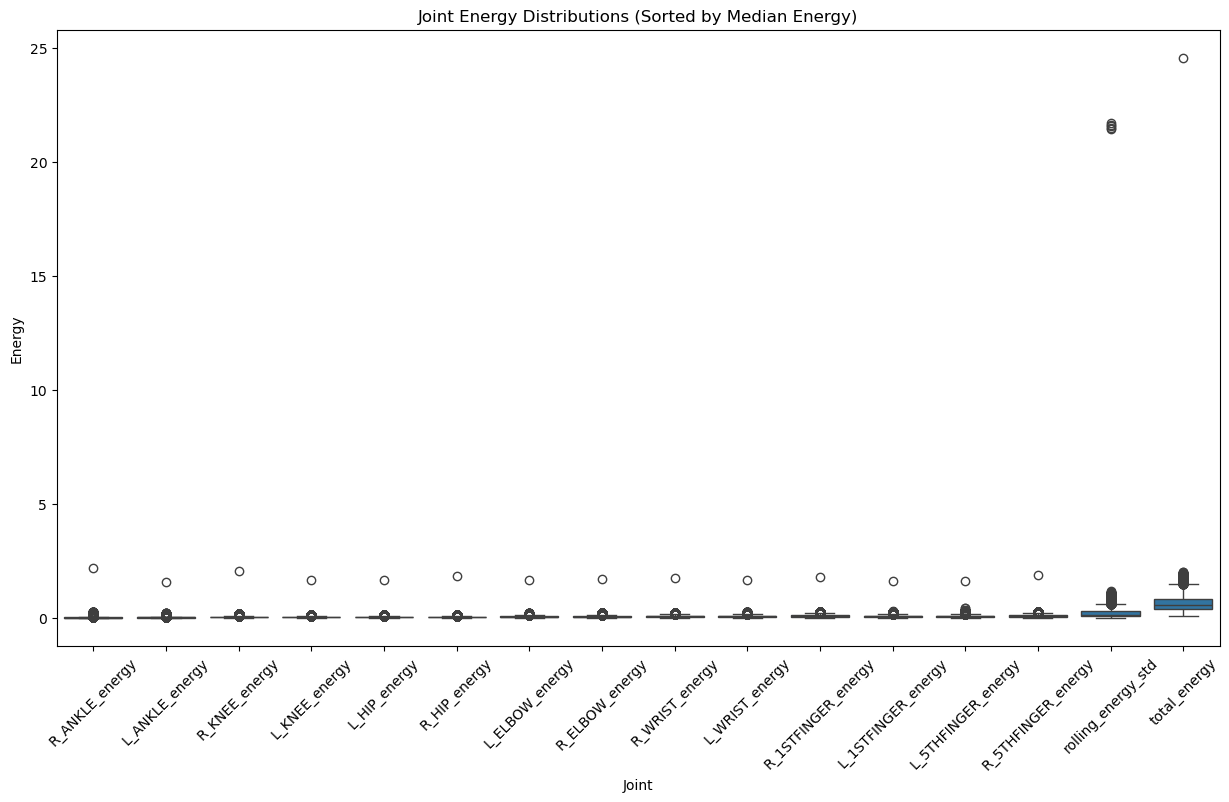

INFO: Displayed boxplot for joint energy distributions.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the app

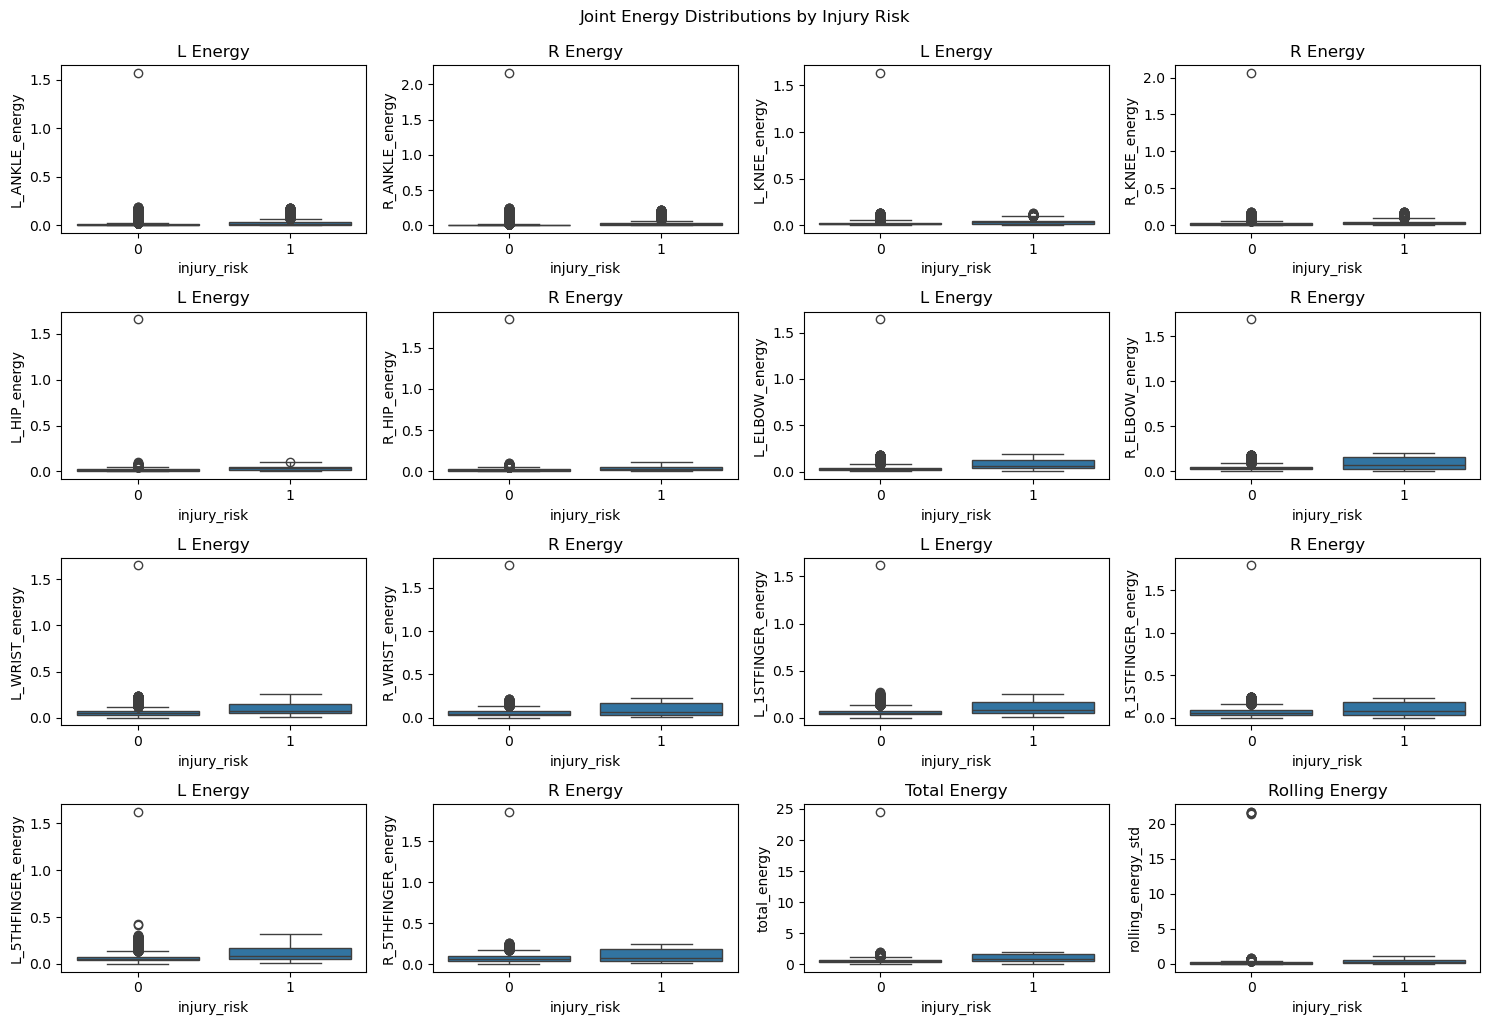

INFO: Displayed injury risk analysis plots for joint energy.


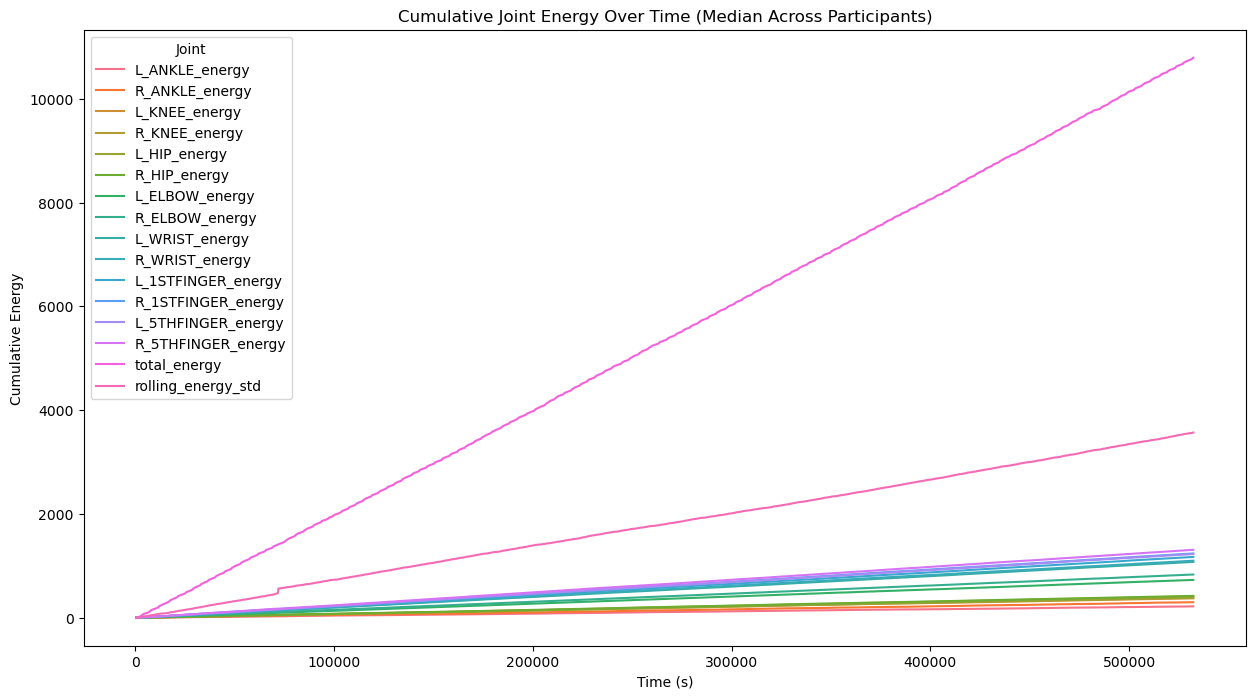

INFO: Displayed cumulative joint energy plot.
INFO: Step [joint_specific_analysis]: DataFrame shape = (15904, 237)
INFO: No angular velocity columns found.


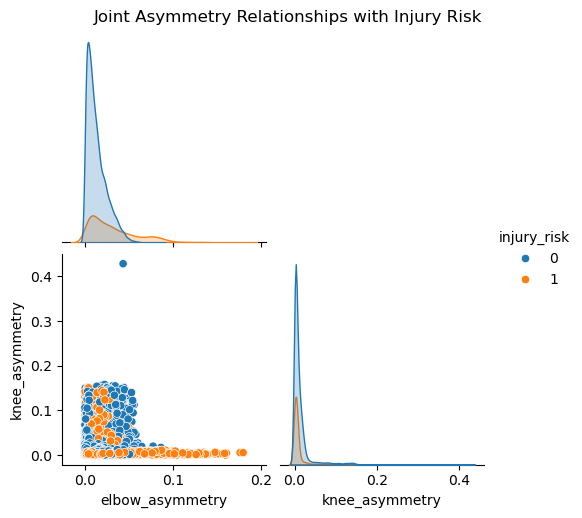

INFO: Displayed asymmetry pairplot.
INFO: Step [movement_pattern_analysis]: DataFrame shape = (15904, 237)


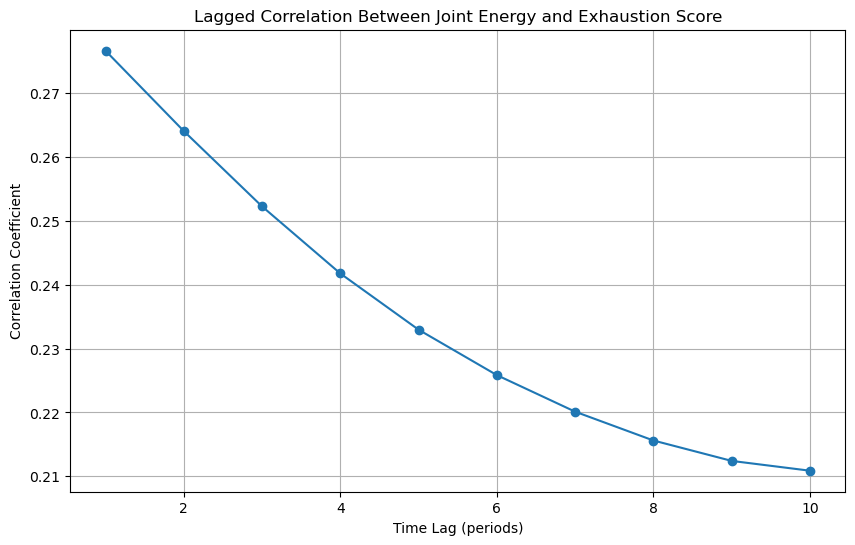

<Figure size 1200x600 with 0 Axes>

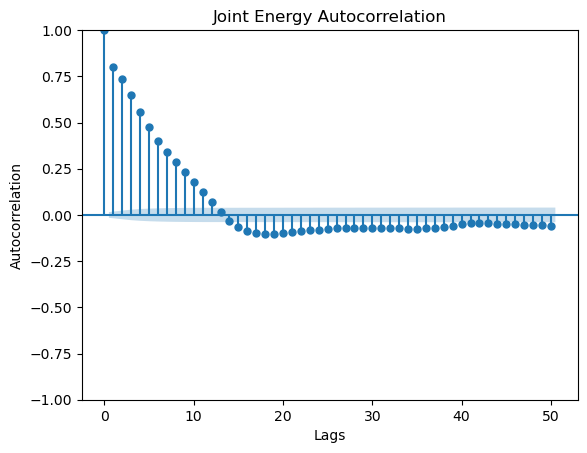

INFO: Step [temporal_analysis_enhancements]: DataFrame shape = (15904, 237)


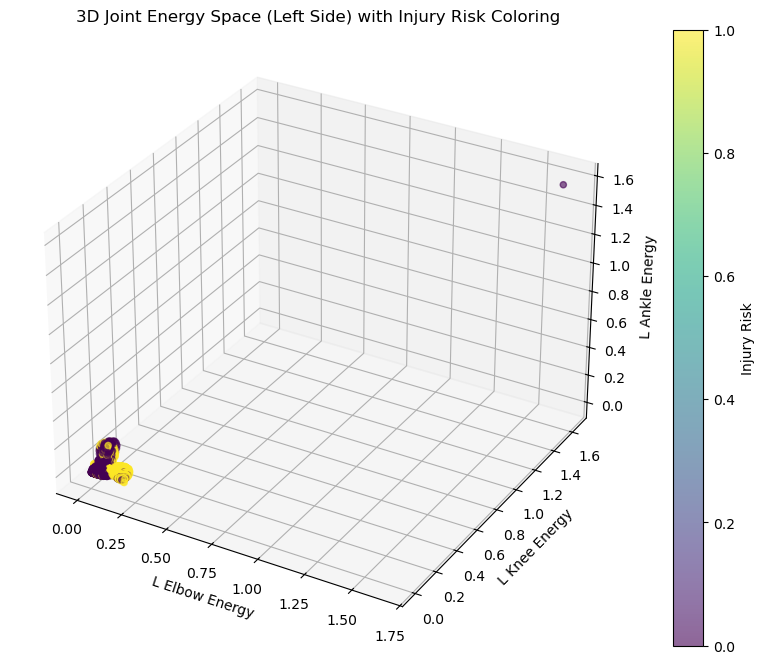

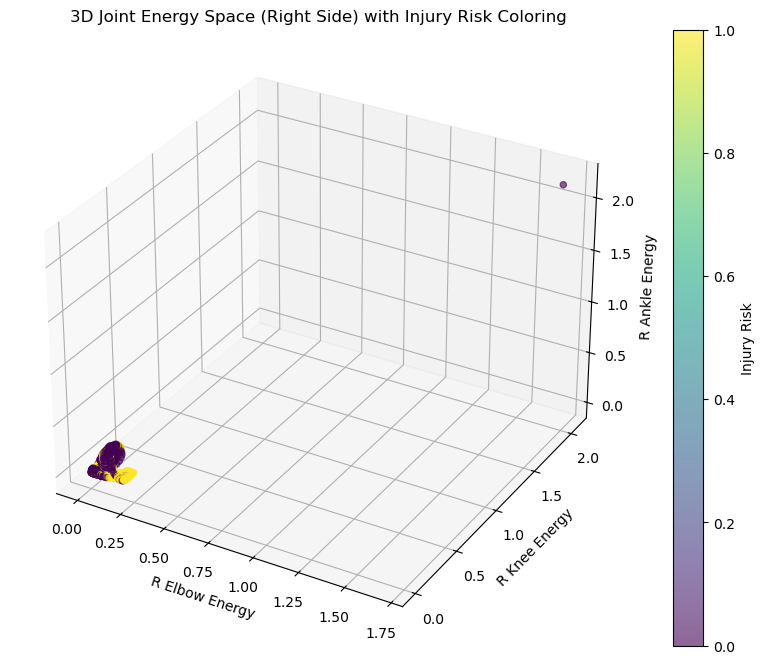

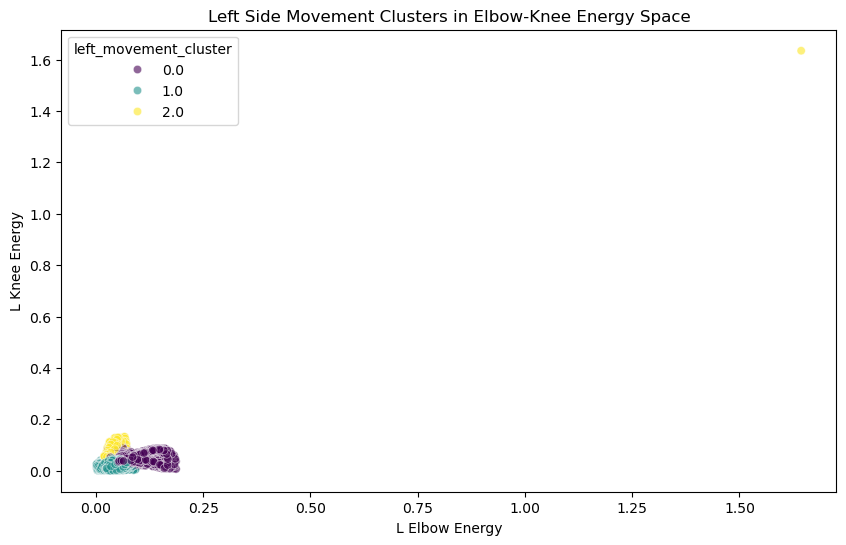

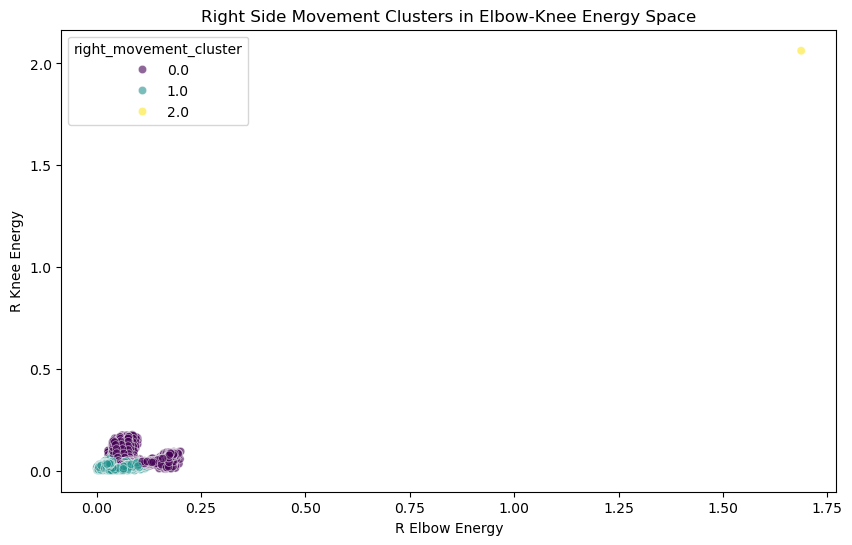

INFO: Step [multivariate_analysis]: DataFrame shape = (15904, 239)
INFO: Mann-Whitney U Test Results:
INFO:       Joint  U Statistic        p-value  Effect Size
0         L   12758125.0   0.000000e+00     0.273325
1         R   12332638.0   0.000000e+00     0.264209
2         L   12985062.5   0.000000e+00     0.278187
3         R   13355779.0   0.000000e+00     0.286129
4         L   12719866.5   0.000000e+00     0.272505
5         R   12068523.5   0.000000e+00     0.258551
6         L    7476182.0   0.000000e+00     0.160167
7         R   12630354.5   0.000000e+00     0.270587
8         L   12941991.0   0.000000e+00     0.277264
10        L   13892233.5   0.000000e+00     0.297621
14    total   12148331.0   0.000000e+00     0.260261
12        L   14295636.5  2.032307e-289     0.306264
15  rolling   15285022.0  5.364174e-230     0.327460
9         R   17309011.0  8.015260e-130     0.370821
11        R   18706280.0   2.034229e-77     0.400755
13        R   19015108.0   1.112328e-67     

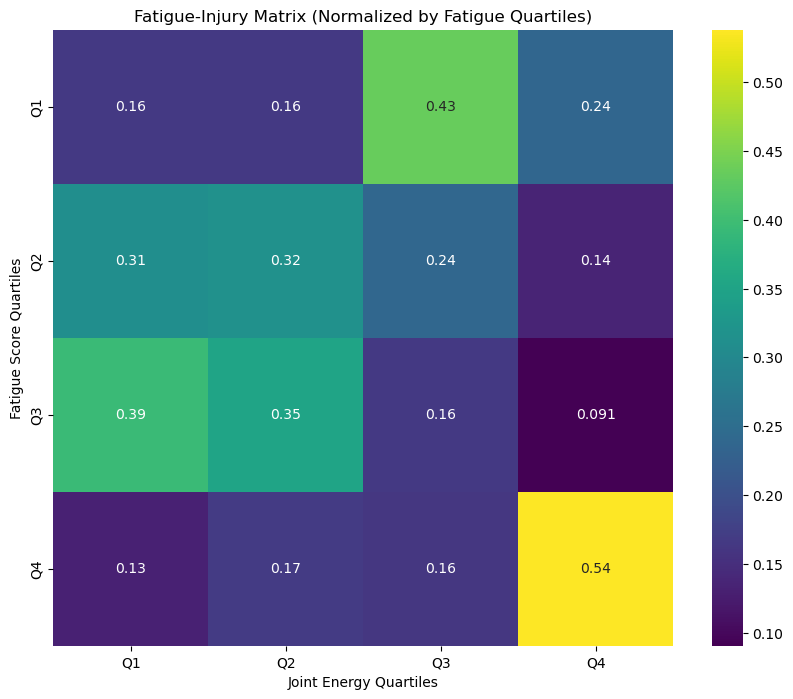

C:\Users\ghadf\AppData\Local\Temp\ipykernel_2264\3230008780.py:646: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_interaction = X_interaction.fillna(method='ffill').fillna(method='bfill')


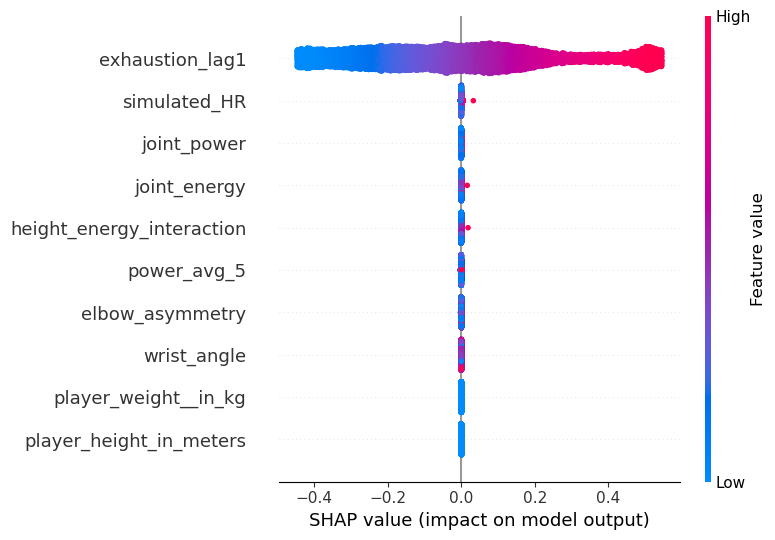

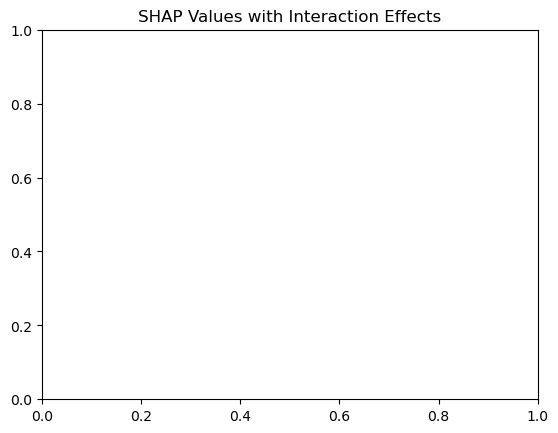

INFO: Step [fatigue_injury_interaction_analysis]: DataFrame shape = (15904, 239)
INFO: Processing pipeline completed successfully.


In [1]:
import numpy as np
import pandas as pd
import json
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import shap

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


###############################################################################
# HELPER FUNCTION FOR DEBUG OUTPUTS
###############################################################################
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    
    When debug=True, prints:
      - The step name.
      - The DataFrame shape.
      - If new_columns is provided (a list of column names), prints for each:
          • Data type and a sample of unique values (up to 5).
    When debug=False, prints a single-line message indicating step completion.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")


###############################################################################
# FUNCTION DEFINITIONS
###############################################################################
def load_data(csv_path, json_path, participant_id='P0001', debug=False):
    """
    Loads the main dataset and participant information, then merges them.
    
    Parameters:
      - csv_path (str): Path to the main CSV file.
      - json_path (str): Path to the participant information JSON file.
      - participant_id (str): Participant identifier.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): Merged DataFrame.
    """
    # Load main dataset
    try:
        data = pd.read_csv(csv_path)
        logging.info(f"Loaded data from {csv_path} with shape {data.shape}")
    except FileNotFoundError:
        logging.error(f"File not found: {csv_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {csv_path}: {e}")
        sys.exit(1)
    
    data['participant_id'] = participant_id
    logging.info(f"Added 'participant_id' column with value '{participant_id}'")
    
    # Load participant info
    try:
        with open(json_path, 'r') as file:
            participant_info = json.load(file)
        participant_df = pd.DataFrame([participant_info])
        logging.info(f"Loaded participant information from {json_path}")
    except FileNotFoundError:
        logging.error(f"File not found: {json_path}")
        sys.exit(1)
    except json.JSONDecodeError:
        logging.error(f"Invalid JSON format in {json_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {json_path}: {e}")
        sys.exit(1)
    
    data = pd.merge(data, participant_df, on='participant_id', how='left')
    logging.info(f"Merged participant data. New shape: {data.shape}")
    _print_debug_info("load_data", data, debug=debug)
    return data


def prepare_joint_features(data, debug=False):
    """
    Aggregates joint-level energy and power, creates additional biomechanical features,
    and adds new features:
      - energy_acceleration: instantaneous rate of change of joint_energy.
      - ankle_power_ratio: ratio of left to right ankle ongoing power.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame.
    """
    step = "prepare_joint_features"
    new_cols = []

    # Rename participant anthropometrics if available
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometric columns not found during renaming.")
    
    # Identify joint energy and power columns
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    joint_power_columns = [col for col in data.columns if '_ongoing_power' in col]
    
    logging.info(f"Identified {len(joint_energy_columns)} joint energy and {len(joint_power_columns)} joint power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found. Check naming conventions.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found. Check naming conventions.")
        sys.exit(1)
    
    # Create aggregated columns
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")
    
    # --- NEW FEATURE: Energy Acceleration ---
    if 'continuous_frame_time' in data.columns:
        data['energy_acceleration'] = data['joint_energy'].diff() / data['continuous_frame_time'].diff()
        new_cols.append('energy_acceleration')
        logging.info("Created 'energy_acceleration' feature as derivative of joint_energy over time.")
    else:
        logging.error("Missing 'continuous_frame_time' for energy_acceleration calculation.")
        sys.exit(1)
    
    # --- NEW FEATURE: Ankle Power Ratio ---
    if 'L_ANKLE_ongoing_power' in data.columns and 'R_ANKLE_ongoing_power' in data.columns:
        data['ankle_power_ratio'] = data['L_ANKLE_ongoing_power'] / (data['R_ANKLE_ongoing_power'] + 1e-6)
        new_cols.append('ankle_power_ratio')
        logging.info("Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.")
    else:
        logging.warning("Ankle ongoing power columns not found; 'ankle_power_ratio' not created.")
    
    # Sort for time analysis
    if 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'participant_id' and 'continuous_frame_time'.")
    else:
        logging.error("Missing required columns for sorting ('participant_id', 'continuous_frame_time').")
        sys.exit(1)
    
    # Create asymmetry features (requires these columns to exist)
    for col in ['L_ELBOW_energy', 'R_ELBOW_energy', 'L_KNEE_energy', 'R_KNEE_energy']:
        if col not in data.columns:
            logging.error(f"Missing required column for asymmetry: '{col}'")
            sys.exit(1)
    data['elbow_asymmetry'] = (data['L_ELBOW_energy'] - data['R_ELBOW_energy']).abs()
    data['knee_asymmetry'] = (data['L_KNEE_energy'] - data['R_KNEE_energy']).abs()
    new_cols.extend(['elbow_asymmetry', 'knee_asymmetry'])
    logging.info("Created asymmetry features.")
    
    # Create exhaustion_rate (requires by_trial_exhaustion_score and by_trial_time)
    if 'by_trial_exhaustion_score' in data.columns and 'by_trial_time' in data.columns:
        data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
        new_cols.append('exhaustion_rate')
        logging.info("Created 'exhaustion_rate' feature.")
    else:
        logging.error("Missing columns for 'exhaustion_rate' calculation.")
        sys.exit(1)
    
    # Create simulated_HR (requires by_trial_exhaustion_score and joint_energy)
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['by_trial_exhaustion_score'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR' feature.")
    else:
        logging.error("Missing columns for 'simulated_HR' calculation.")
        sys.exit(1)
    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data



def feature_engineering(data, debug=False):
    """
    Performs additional feature engineering steps.
    
    Parameters:
      - data (pd.DataFrame): DataFrame after joint feature preparation.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): DataFrame with new engineered features.
    """
    step = "feature_engineering"
    new_cols = []
    window_size = 5  # used for rolling statistics
    
    if 'by_trial_exhaustion_score' in data.columns:
        data['exhaustion_lag1'] = data['by_trial_exhaustion_score'].shift(1)
        new_cols.append('exhaustion_lag1')
        logging.info("Created 'exhaustion_lag1'.")
    else:
        logging.error("Missing 'by_trial_exhaustion_score' for 'exhaustion_lag1'.")
        sys.exit(1)
    
    if 'joint_power' in data.columns:
        data['power_avg_5'] = data['joint_power'].rolling(window=window_size).mean()
        new_cols.append('power_avg_5')
        logging.info("Created 'power_avg_5'.")
    else:
        logging.error("Missing 'joint_power' for 'power_avg_5'.")
        sys.exit(1)
    
    if 'joint_power' in data.columns:
        data['rolling_power_std'] = data['joint_power'].rolling(window=window_size).std()
        new_cols.append('rolling_power_std')
        logging.info(f"Created 'rolling_power_std' with window {window_size}.")
    else:
        logging.error("Missing 'joint_power' for 'rolling_power_std'.")
        sys.exit(1)
    
    if 'simulated_HR' in data.columns:
        data['rolling_hr_mean'] = data['simulated_HR'].rolling(window=window_size).mean()
        new_cols.append('rolling_hr_mean')
        logging.info(f"Created 'rolling_hr_mean' with window {window_size}.")
    else:
        logging.error("Missing 'simulated_HR' for 'rolling_hr_mean'.")
        sys.exit(1)
    
    if 'continuous_frame_time' in data.columns:
        data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
        new_cols.append('time_since_start')
        logging.info("Created 'time_since_start'.")
    else:
        logging.error("Missing 'continuous_frame_time' for 'time_since_start'.")
        sys.exit(1)
    
    if 'by_trial_exhaustion_score' in data.columns:
        data['ema_exhaustion'] = data['by_trial_exhaustion_score'].ewm(span=10, adjust=False).mean()
        new_cols.append('ema_exhaustion')
        logging.info("Created 'ema_exhaustion'.")
    else:
        logging.error("Missing 'by_trial_exhaustion_score' for 'ema_exhaustion'.")
        sys.exit(1)
    
    rolling_window = 20
    if 'by_trial_exhaustion_score' in data.columns:
        data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(window=rolling_window).sum()
        new_cols.append('rolling_exhaustion')
        logging.info(f"Created 'rolling_exhaustion' with window {rolling_window}.")
    else:
        logging.error("Missing 'by_trial_exhaustion_score' for 'rolling_exhaustion'.")
        sys.exit(1)
    
    if 'rolling_exhaustion' in data.columns:
        quantile_75 = data['rolling_exhaustion'].quantile(0.75)
        data['injury_risk'] = np.where(data['rolling_exhaustion'] > quantile_75, 1, 0)
        new_cols.append('injury_risk')
        logging.info("Created 'injury_risk' based on 'rolling_exhaustion'.")
    else:
        logging.error("Missing 'rolling_exhaustion' for 'injury_risk' update.")
        sys.exit(1)
    
    # --- OPTIONAL NEW FEATURE: Rolling Energy Standard Deviation ---
    if 'joint_energy' in data.columns:
        data['rolling_energy_std'] = data['joint_energy'].rolling(window=window_size).std()
        new_cols.append('rolling_energy_std')
        logging.info(f"Created 'rolling_energy_std' with window {window_size}.")
    else:
        logging.warning("Column 'joint_energy' missing for 'rolling_energy_std'.")
    
    initial_shape = data.shape
    data.dropna(inplace=True)
    new_shape = data.shape
    logging.info(f"Dropped rows with missing values: shape {initial_shape} -> {new_shape}")
    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data




def add_simulated_player_metrics(df, window=5, debug=False):
    """
    Adds simulated player metrics to mimic heart rate and fatigue.
    
    New Metrics:
      - simulated_HR_fake: Alternative simulated heart rate.
      - fatigue_index_fake: Combined fatigue index.
      - fatigue_rate_fake: Frame-by-frame rate of change of fatigue_index_fake.
      - HR_variability_fake: Rolling standard deviation of simulated_HR_fake.
    
    Parameters:
      - df (pd.DataFrame): DataFrame with required columns (e.g., by_trial_exhaustion_score, joint_energy, overall_exhaustion_score, dt).
      - window (int): Rolling window size for HR variability.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): DataFrame with new simulated metrics.
    """
    step = "add_simulated_player_metrics"
    new_cols = []
    
    # Use maximum joint_energy for scaling
    max_joint_energy = df['joint_energy'].max() if 'joint_energy' in df.columns else 1
    df['simulated_HR_fake'] = 60 + (df['by_trial_exhaustion_score'] * 2.0) + ((df['joint_energy'] / max_joint_energy) * 20)
    new_cols.append('simulated_HR_fake')
    
    df['fatigue_index_fake'] = df['overall_exhaustion_score'] + ((df['simulated_HR_fake'] - 60) / 100)
    new_cols.append('fatigue_index_fake')
    
    df['fatigue_rate_fake'] = df['fatigue_index_fake'].diff() / df['dt']
    df['fatigue_rate_fake'] = df['fatigue_rate_fake'].fillna(0)
    new_cols.append('fatigue_rate_fake')
    
    df['HR_variability_fake'] = df['simulated_HR_fake'].rolling(window=window, min_periods=1).std()
    new_cols.append('HR_variability_fake')
    
    _print_debug_info(step, df, new_columns=new_cols, debug=debug)
    return df


def joint_specific_analysis(data, joint_energy_columns, debug=False):
    """
    Performs joint-specific analysis including:
      - Energy distribution per joint.
      - Injury risk analysis for each joint.
      - Cumulative energy accumulation patterns.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints debug information.
    """
    step = "joint_specific_analysis"
    # Energy distribution across joints
    joint_energy_melted = data[joint_energy_columns].melt(var_name='Joint', value_name='Energy')
    plt.figure(figsize=(15, 8))
    order = joint_energy_melted.groupby('Joint')['Energy'].median().sort_values().index
    sns.boxplot(x='Joint', y='Energy', data=joint_energy_melted, order=order)
    plt.title('Joint Energy Distributions (Sorted by Median Energy)')
    plt.xticks(rotation=45)
    plt.show()
    if debug:
        logging.info("Displayed boxplot for joint energy distributions.")
    else:
        logging.info("Energy distribution plot displayed.")
    
    # Injury risk analysis: only run if 'injury_risk' exists.
    if 'injury_risk' not in data.columns:
        logging.warning("Column 'injury_risk' not found; skipping injury risk analysis in joint_specific_analysis.")
    else:
        num_plots = len(joint_energy_columns)
        ncols = 4
        nrows = int(np.ceil(num_plots / ncols))
        plt.figure(figsize=(15, 10))
        for i, joint in enumerate(joint_energy_columns, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x='injury_risk', y=joint, data=data)
            plt.title(f'{joint.split("_")[0].title()} Energy')
            plt.tight_layout()
        plt.suptitle('Joint Energy Distributions by Injury Risk', y=1.02)
        plt.show()
        if debug:
            logging.info("Displayed injury risk analysis plots for joint energy.")
        else:
            logging.info("Injury risk analysis plots displayed.")
    
    # Cumulative energy accumulation patterns
    joint_cumulative = data.groupby('participant_id')[joint_energy_columns].cumsum()
    joint_cumulative['time'] = data['continuous_frame_time']
    joint_cumulative_melted = joint_cumulative.melt(id_vars='time', var_name='Joint', value_name='Cumulative Energy')
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='time', y='Cumulative Energy', hue='Joint', 
                 data=joint_cumulative_melted, estimator='median', errorbar=None)
    plt.title('Cumulative Joint Energy Over Time (Median Across Participants)')
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Energy')
    plt.show()
    if debug:
        logging.info("Displayed cumulative joint energy plot.")
    else:
        logging.info("Cumulative energy plot displayed.")
    
    _print_debug_info(step, data, debug=debug)


def movement_pattern_analysis(data, debug=False):
    """
    Performs movement pattern analysis:
      - Angular velocity histograms with KDE.
      - Asymmetry analysis via pairplot.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "movement_pattern_analysis"
    # Angular velocity analysis
    angular_columns = [col for col in data.columns if '_angular_velocity' in col]
    if angular_columns:
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
        axes = axes.flatten()
        for ax, col in zip(axes, angular_columns):
            sns.histplot(data[col], ax=ax, kde=True)
            ax.set_title(f'{col.split("_")[0].title()} Angular Velocity')
        for j in range(len(angular_columns), len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
        logging.info("Displayed angular velocity histograms.")
    else:
        logging.info("No angular velocity columns found.")
    
    # Asymmetry analysis
    asymmetry_metrics = [col for col in data.columns if 'asymmetry' in col]
    if 'injury_risk' in data.columns and asymmetry_metrics:
        sns.pairplot(data[asymmetry_metrics + ['injury_risk']], hue='injury_risk', corner=True)
        plt.suptitle('Joint Asymmetry Relationships with Injury Risk', y=1.02)
        plt.show()
        logging.info("Displayed asymmetry pairplot.")
    else:
        logging.info("Required columns for asymmetry analysis not found.")
    
    _print_debug_info(step, data, debug=debug)


def temporal_analysis_enhancements(data, debug=False):
    """
    Performs temporal analysis enhancements:
      - Computes lagged correlations between joint energy and exhaustion score.
      - Plots autocorrelation of joint energy.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "temporal_analysis_enhancements"
    max_lag = 10
    lagged_corrs = []
    for lag in range(1, max_lag + 1):
        corr_val = data['joint_energy'].corr(data['by_trial_exhaustion_score'].shift(lag))
        lagged_corrs.append(corr_val)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lag + 1), lagged_corrs, marker='o')
    plt.title('Lagged Correlation Between Joint Energy and Exhaustion Score')
    plt.xlabel('Time Lag (periods)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 6))
    plot_acf(data['joint_energy'].dropna(), lags=50, alpha=0.05)
    plt.title('Joint Energy Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    _print_debug_info(step, data, debug=debug)


def multivariate_analysis(data, joint_energy_columns, debug=False):
    """
    Performs multivariate analysis separately for left- and right-sided joints:
      - 3D visualization of joint energy interactions for each side.
      - KMeans clustering on selected features for each side.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of all joint energy columns.
      - debug (bool): If True, prints debug information.
    """
    step = "multivariate_analysis"

    # --- 3D Visualization: Left Side ---
    required_left = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_left):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['L_ELBOW_energy'], 
                             data['L_KNEE_energy'], 
                             data['L_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('L Elbow Energy')
        ax.set_ylabel('L Knee Energy')
        ax.set_zlabel('L Ankle Energy')
        plt.title('3D Joint Energy Space (Left Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required left-side columns for 3D analysis not found; skipping left side 3D plot.")

    # --- 3D Visualization: Right Side ---
    required_right = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_right):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['R_ELBOW_energy'], 
                             data['R_KNEE_energy'], 
                             data['R_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('R Elbow Energy')
        ax.set_ylabel('R Knee Energy')
        ax.set_zlabel('R Ankle Energy')
        plt.title('3D Joint Energy Space (Right Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required right-side columns for 3D analysis not found; skipping right side 3D plot.")

    # --- Clustering Analysis: Left Side ---
    left_features = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy']
    # Optionally include asymmetry features if desired (they compare L vs R)
    left_features = [feat for feat in left_features if feat in data.columns]
    if left_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_left = data[left_features].dropna()
        X_left_scaled = StandardScaler().fit_transform(X_left)
        kmeans_left = KMeans(n_clusters=3, random_state=42).fit(X_left_scaled)
        data.loc[X_left.index, 'left_movement_cluster'] = kmeans_left.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='L_ELBOW_energy', y='L_KNEE_energy', hue='left_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Left Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('L Elbow Energy')
        plt.ylabel('L Knee Energy')
        plt.show()
    else:
        logging.info("Not enough left-side features available for clustering analysis.")

    # --- Clustering Analysis: Right Side ---
    right_features = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy']
    right_features = [feat for feat in right_features if feat in data.columns]
    if right_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_right = data[right_features].dropna()
        X_right_scaled = StandardScaler().fit_transform(X_right)
        kmeans_right = KMeans(n_clusters=3, random_state=42).fit(X_right_scaled)
        data.loc[X_right.index, 'right_movement_cluster'] = kmeans_right.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='R_ELBOW_energy', y='R_KNEE_energy', hue='right_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Right Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('R Elbow Energy')
        plt.ylabel('R Knee Energy')
        plt.show()
    else:
        logging.info("Not enough right-side features available for clustering analysis.")

    _print_debug_info(step, data, debug=debug)



def statistical_testing(data, joint_energy_columns, debug=False):
    """
    Performs Mann-Whitney U tests on each joint energy metric between low and high injury risk groups.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints detailed test outputs.
    
    Returns:
      - results_df (pd.DataFrame): Summary table of test statistics.
    """
    from scipy.stats import mannwhitneyu
    step = "statistical_testing"
    results = []
    for joint in joint_energy_columns:
        if joint in data.columns and 'injury_risk' in data.columns:
            low_risk = data[data['injury_risk'] == 0][joint]
            high_risk = data[data['injury_risk'] == 1][joint]
            stat, p = mannwhitneyu(low_risk, high_risk, alternative='two-sided')
            effect_size = stat / (len(low_risk) * len(high_risk)) if (len(low_risk) * len(high_risk)) > 0 else np.nan
            results.append({
                'Joint': joint.split('_')[0],
                'U Statistic': stat,
                'p-value': p,
                'Effect Size': effect_size
            })
    results_df = pd.DataFrame(results).sort_values('p-value')
    logging.info("Mann-Whitney U Test Results:")
    logging.info(results_df)
    _print_debug_info(step, data, debug=debug)
    return results_df


def fatigue_injury_interaction_analysis(data, features_exhaustion, target_exhaustion, debug=False):
    """
    Analyzes fatigue-injury interactions by constructing a fatigue-injury matrix and evaluating interaction effects.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - features_exhaustion (list): Feature list for exhaustion prediction.
      - target_exhaustion (str): Exhaustion target variable.
      - debug (bool): If True, prints detailed debug outputs.
    """
    step = "fatigue_injury_interaction_analysis"
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        fatigue_bins = pd.qcut(data['by_trial_exhaustion_score'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        joint_energy_bins = pd.qcut(data['joint_energy'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        fatigue_injury_matrix = pd.crosstab(fatigue_bins, joint_energy_bins, normalize='index')
        plt.figure(figsize=(10, 8))
        sns.heatmap(fatigue_injury_matrix, annot=True, cmap='viridis')
        plt.title('Fatigue-Injury Matrix (Normalized by Fatigue Quartiles)')
        plt.xlabel('Joint Energy Quartiles')
        plt.ylabel('Fatigue Score Quartiles')
        plt.show()
    else:
        logging.info("Required columns for fatigue-injury matrix not found; skipping this analysis.")
    
    if 'player_height_in_meters' in data.columns and 'joint_energy' in data.columns:
        X_interaction = data[features_exhaustion].copy()
        if 'player_height_in_meters' in X_interaction.columns and 'joint_energy' in X_interaction.columns:
            X_interaction['height_energy_interaction'] = X_interaction['player_height_in_meters'] * X_interaction['joint_energy']
            X_interaction = X_interaction.fillna(method='ffill').fillna(method='bfill')
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_interaction, data[target_exhaustion])
            explainer_interaction = shap.TreeExplainer(model)
            shap_interaction = explainer_interaction.shap_values(X_interaction)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_interaction, X_interaction, max_display=15)
            plt.title('SHAP Values with Interaction Effects')
            plt.show()
        else:
            logging.info("Required columns for interaction effect missing; skipping SHAP analysis.")
    else:
        logging.info("Required columns for interaction effect not found; skipping SHAP analysis.")
    
    _print_debug_info(step, data, debug=debug)


###############################################################################
# MAIN SCRIPT
###############################################################################
def main(debug=False, csv_path="../data/processed/final_granular_dataset.csv",
         json_path="../data/basketball/freethrow/participant_information.json"):
    """
    Main processing pipeline:
      1. Loads and merges data.
      2. Prepares joint features.
      3. Performs feature engineering.
      4. Adds simulated player metrics.
      5. Executes various analyses (joint-specific, movement pattern, temporal, multivariate, statistical, and fatigue-injury interaction).
    
    Parameters:
      - debug (bool): Controls verbose debug output.
      - csv_path (str): Path to input CSV file.
      - json_path (str): Path to participant info JSON.
    """
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    data = add_simulated_player_metrics(data, window=5, debug=debug)
    
    # For demonstration, define features/targets (you can adjust these as needed)
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'
    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    
    # Identify joint energy columns (excluding the aggregated 'joint_energy')
    joint_energy_columns = [
        col for col in data.columns
        if '_energy' in col and not ('by_trial' in col or 'overall' in col) and col != 'joint_energy'
    ]
    logging.info(f"Joint Energy Columns after excluding 'joint_energy' ({len(joint_energy_columns)}): {joint_energy_columns}")
    
    # Execute analysis functions
    joint_specific_analysis(data, joint_energy_columns, debug=debug)
    movement_pattern_analysis(data, debug=debug)
    temporal_analysis_enhancements(data, debug=debug)
    multivariate_analysis(data, joint_energy_columns, debug=debug)
    statistical_testing(data, joint_energy_columns, debug=debug)
    fatigue_injury_interaction_analysis(data, features_exhaustion, target_exhaustion, debug=debug)
    
    logging.info("Processing pipeline completed successfully.")


if __name__ == "__main__":
    # Run the main pipeline with debug output enabled.
    main(debug=True)


# Feature Engineering

INFO: Loaded data from ../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' feature as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created asymmetry features.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features] completed.
INFO: Created 'exhaustion_lag1' feature.
INFO: Created 'power_avg_5' feature.
INFO: Created 'rolling_p

   trial_id  result  landing_x  landing_y  entry_angle  frame_time  ball_x  \
19    T0001       0       7.15     12.755         40.9        2833  32.294   
20    T0001       0       7.15     12.755         40.9        2866  32.020   
21    T0001       0       7.15     12.755         40.9        2900  31.716   
22    T0001       0       7.15     12.755         40.9        2933  31.354   
23    T0001       0       7.15     12.755         40.9        2966  30.957   

    ball_y  ball_z  R_EYE_x  ...  exhaustion_rate  simulated_HR  \
19  -1.206   0.790   27.334  ...         0.000180     60.479588   
20  -1.178   1.016   27.357  ...         0.000163     60.462463   
21  -1.186   1.303   27.379  ...         0.000146     60.452111   
22  -1.183   1.658   27.398  ...         0.000144     60.450017   
23  -1.160   2.048   27.416  ...         0.000141     60.451883   

    exhaustion_lag1  power_avg_5  rolling_power_std  rolling_hr_mean  \
19         0.137527    15.608373           1.762483     

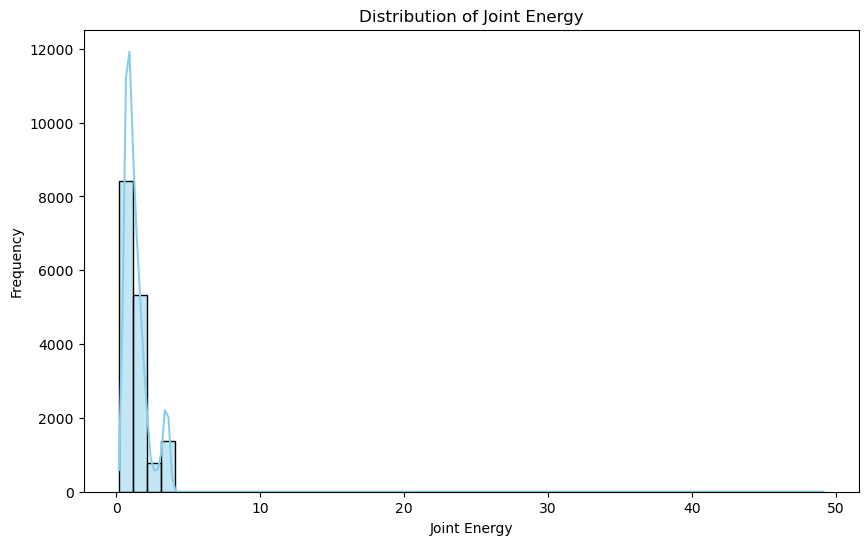

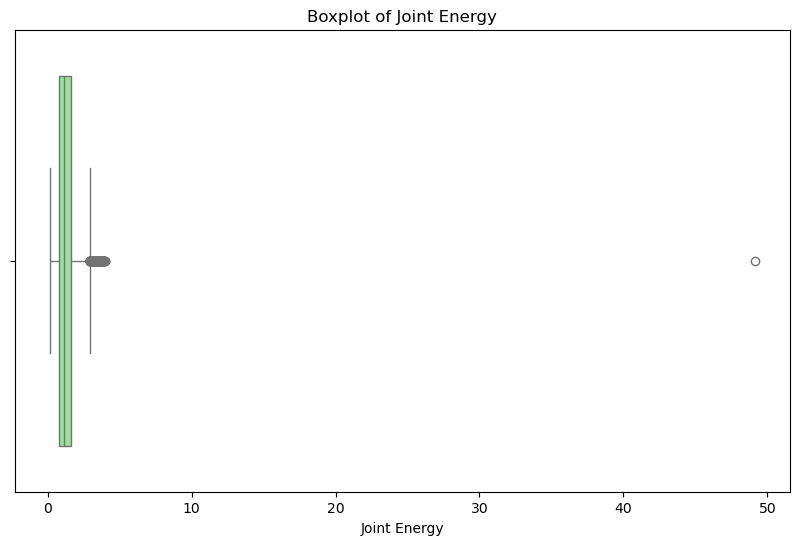

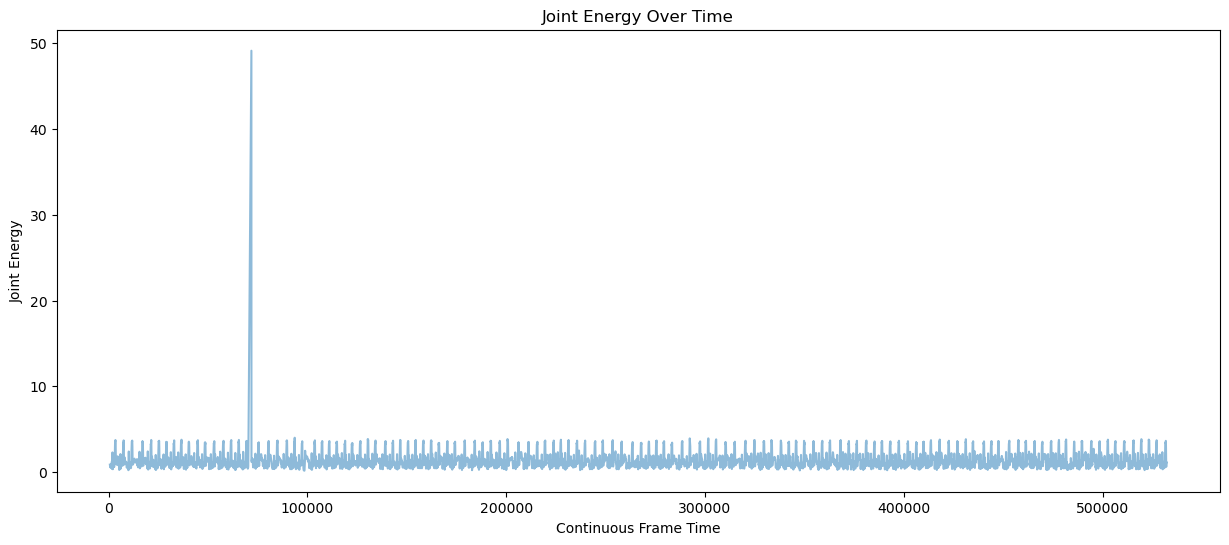

Correlation Matrix computed successfully with shape: (9, 9)
Correlation of Joint Energy with Other Features:
joint_energy               1.000000
joint_power                0.907866
power_avg_5                0.824316
simulated_HR               0.715934
exhaustion_lag1            0.274321
elbow_asymmetry            0.241877
wrist_angle               -0.009594
player_height_in_meters         NaN
player_weight__in_kg            NaN
Name: joint_energy, dtype: float64


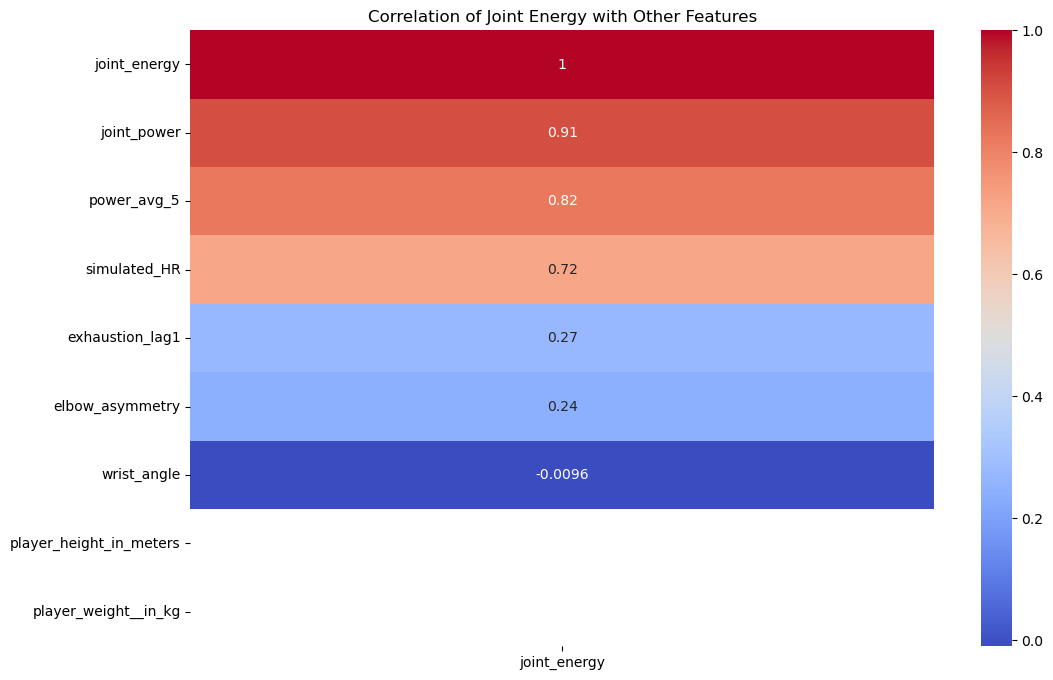

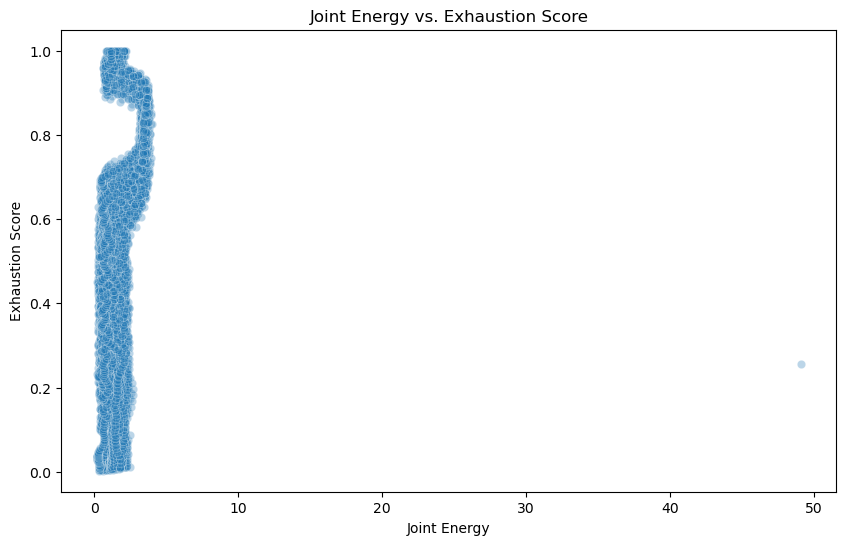

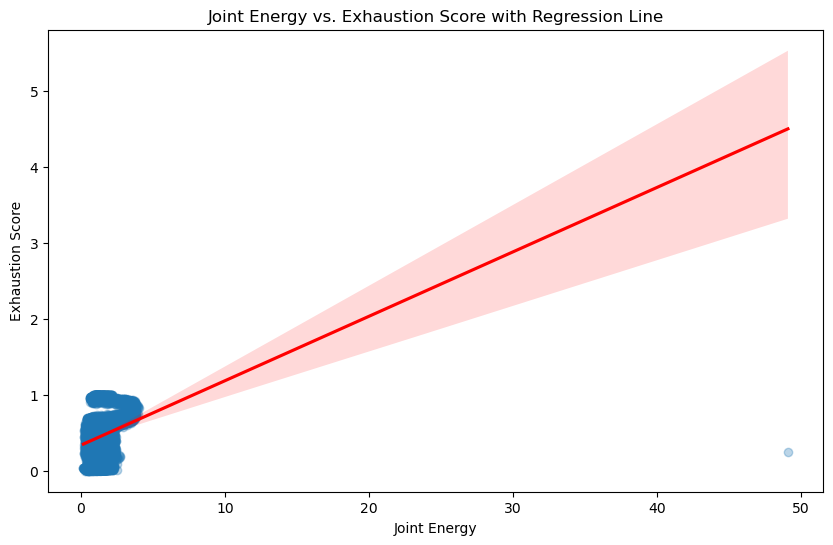

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


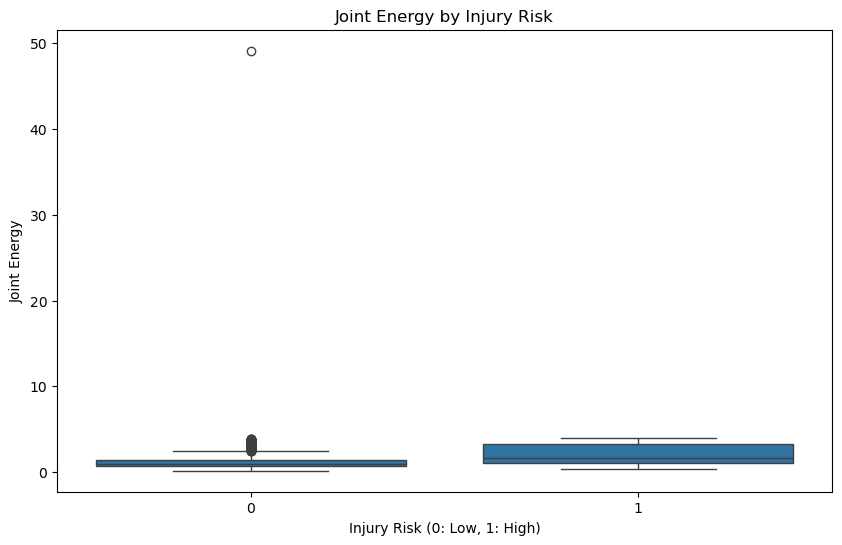

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


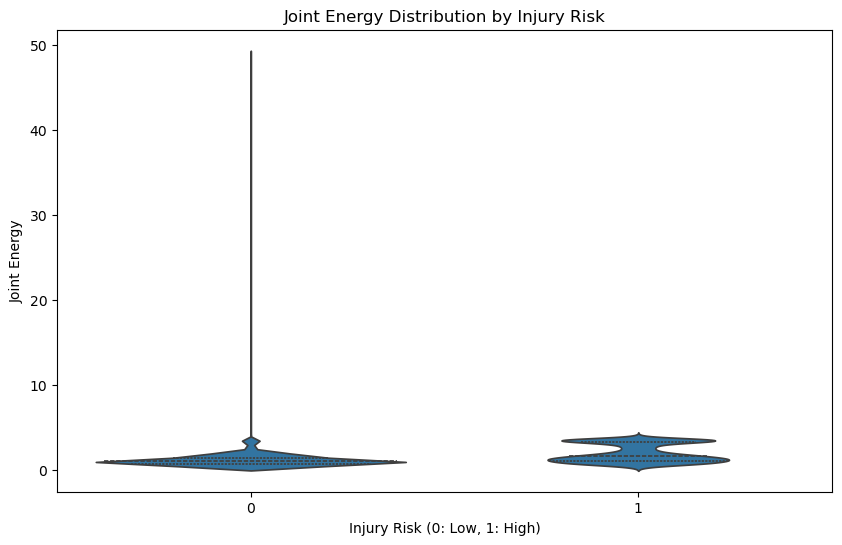

Point-Biserial Correlation between Joint Energy and Injury Risk: 0.3927 (p-value: 0.0000e+00)


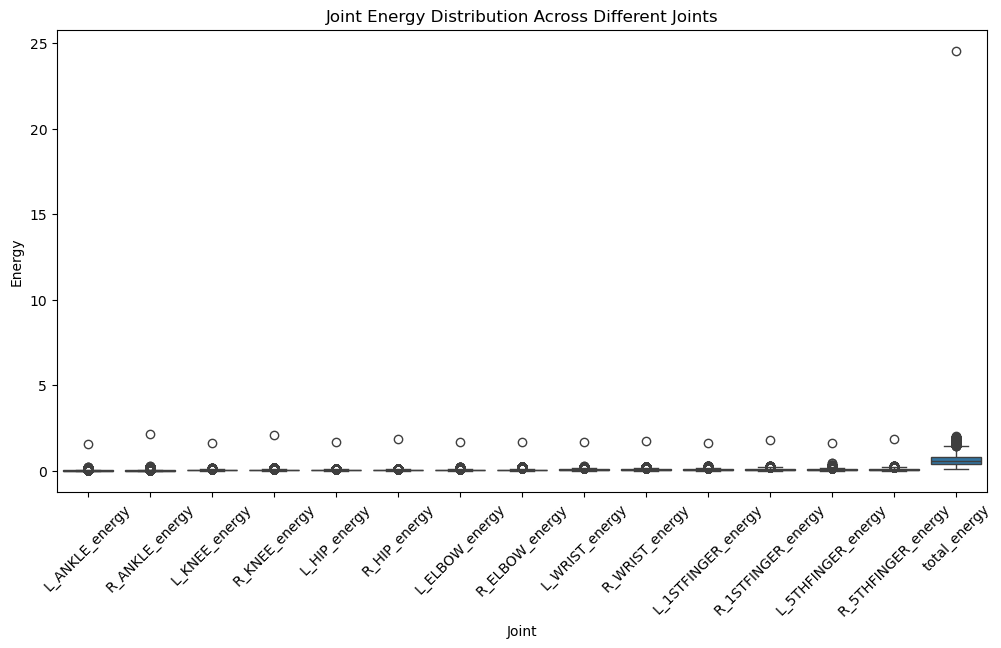

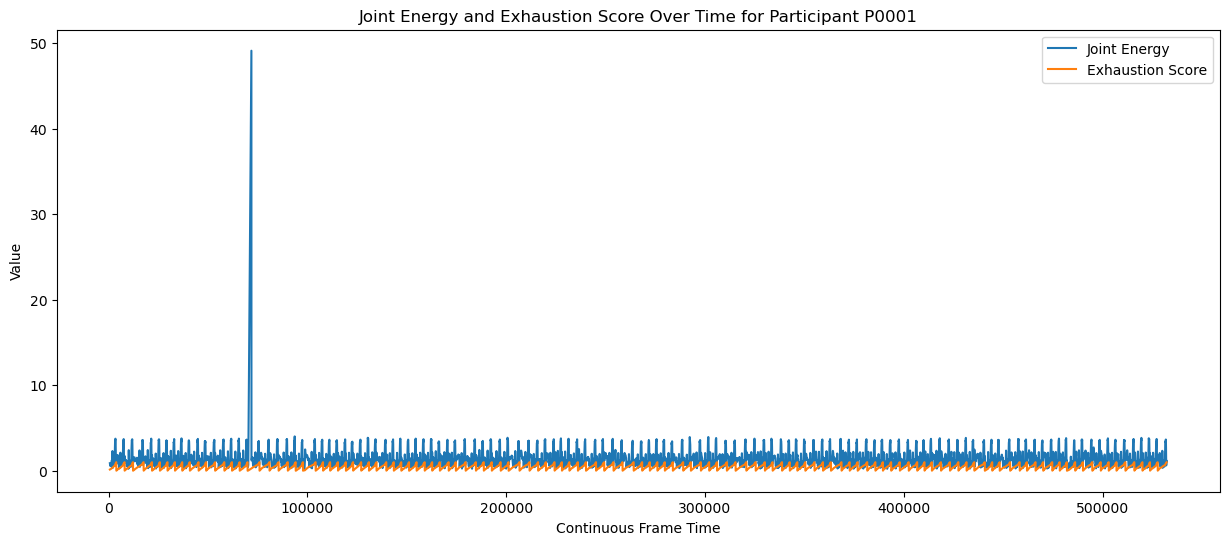

C:\Users\ghadf\AppData\Local\Temp\ipykernel_2264\2486772461.py:313: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')
C:\Users\ghadf\AppData\Local\Temp\ipykernel_2264\2486772461.py:314: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method='ffill').fillna(method='bfill')


Feature Importance:
                   Feature  Importance
4          exhaustion_lag1    1.976358
6             simulated_HR    0.000082
0              joint_power    0.000022
5              power_avg_5    0.000022
1             joint_energy    0.000017
2          elbow_asymmetry    0.000003
3              wrist_angle    0.000001
7  player_height_in_meters    0.000000
8     player_weight__in_kg    0.000000


C:\Users\ghadf\AppData\Local\Temp\ipykernel_2264\2486772461.py:336: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


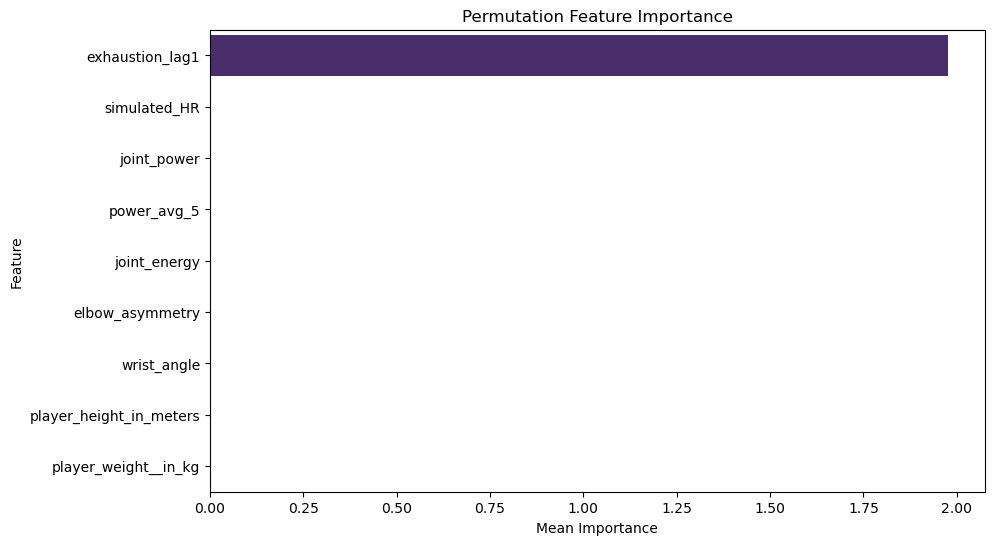

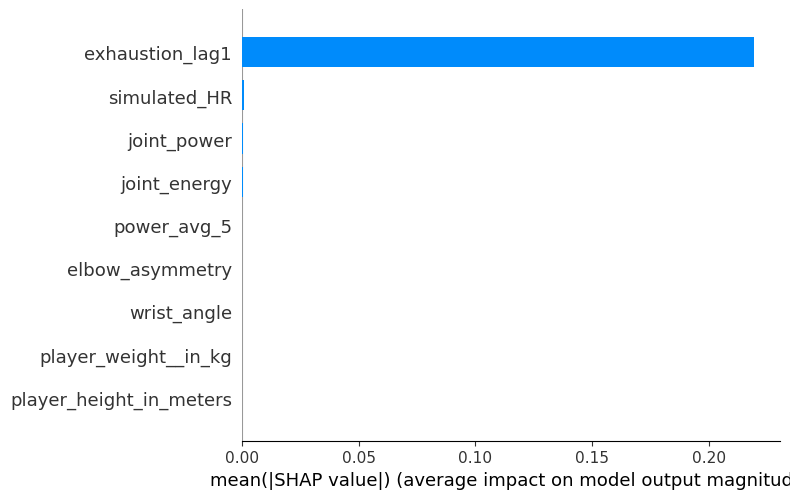

In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
from scipy.stats import pointbiserialr
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap



def feature_engineering(data):
    """
    Performs additional feature engineering steps.
    
    Parameters:
    - data (pd.DataFrame): DataFrame with aggregated features.
    
    Returns:
    - data (pd.DataFrame): DataFrame with engineered features.
    """
    # Create lagged exhaustion score
    if 'by_trial_exhaustion_score' in data.columns:
        data['exhaustion_lag1'] = data['by_trial_exhaustion_score'].shift(1)
        logging.info("Created 'exhaustion_lag1' feature.")
    else:
        logging.error("'by_trial_exhaustion_score' column is missing.")
        sys.exit(1)

    # Create rolling average of 'joint_power' over a window of 5 trials
    if 'joint_power' in data.columns:
        data['power_avg_5'] = data['joint_power'].rolling(window=5).mean()
        logging.info("Created 'power_avg_5' feature.")
    else:
        logging.error("'joint_power' column is missing.")
        sys.exit(1)

    # Add rolling statistical features
    window_size = 5
    if 'joint_power' in data.columns:
        data['rolling_power_std'] = data['joint_power'].rolling(window=window_size).std()
        logging.info(f"Created 'rolling_power_std' with window size {window_size}.")
    else:
        logging.error("'joint_power' column is missing for 'rolling_power_std'.")
        sys.exit(1)

    if 'simulated_HR' in data.columns:
        data['rolling_hr_mean'] = data['simulated_HR'].rolling(window=window_size).mean()
        logging.info(f"Created 'rolling_hr_mean' with window size {window_size}.")
    else:
        logging.error("'simulated_HR' column is missing for 'rolling_hr_mean'.")
        sys.exit(1)

    # Time since session start
    if 'continuous_frame_time' in data.columns:
        data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
        logging.info("Created 'time_since_start' feature.")
    else:
        logging.error("'continuous_frame_time' column is missing for 'time_since_start'.")
        sys.exit(1)

    # Add exponential moving average
    if 'by_trial_exhaustion_score' in data.columns:
        data['ema_exhaustion'] = data['by_trial_exhaustion_score'].ewm(span=10, adjust=False).mean()
        logging.info("Created 'ema_exhaustion' feature.")
    else:
        logging.error("'by_trial_exhaustion_score' column is missing for 'ema_exhaustion'.")
        sys.exit(1)

    # Create a simulated target for injury risk based on rolling exhaustion
    rolling_window = 20
    if 'by_trial_exhaustion_score' in data.columns:
        data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(window=rolling_window).sum()
        logging.info(f"Created 'rolling_exhaustion' with window size {rolling_window}.")
    else:
        logging.error("'by_trial_exhaustion_score' column is missing for 'rolling_exhaustion'.")
        sys.exit(1)

    if 'rolling_exhaustion' in data.columns:
        quantile_75 = data['rolling_exhaustion'].quantile(0.75)
        data['injury_risk'] = np.where(
            data['rolling_exhaustion'] > quantile_75, 
            1, 
            0
        )
        logging.info("Updated 'injury_risk' based on 'rolling_exhaustion' and 75th percentile threshold.")
    else:
        logging.error("'rolling_exhaustion' column is missing for updating 'injury_risk'.")
        sys.exit(1)

    # Drop rows with any missing values resulting from the above operations
    initial_shape = data.shape
    data.dropna(inplace=True)
    final_shape = data.shape
    logging.info(f"Dropped rows with missing values. Shape before: {initial_shape}, after: {final_shape}")

    return data










if __name__ == "__main__":
    # Paths to data files
    csv_path = "../data/processed/final_granular_dataset.csv"
    json_path = "../data/basketball/freethrow/participant_information.json"
    
    # Load and merge data
    data = load_data(csv_path, json_path)
    
    # Prepare joint features and additional engineered features
    data = prepare_joint_features(data)
    data = feature_engineering(data)

    # Define features and targets
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'

    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'

    # Verify all features exist in the DataFrame
    missing_features = [
        feature for feature in features_exhaustion + features_injury 
        if feature not in data.columns
    ]
    if missing_features:
        logging.error(f"Missing features detected: {missing_features}")
        logging.error("Please ensure all required features are present in the dataset.")
        sys.exit(1)
    else:
        logging.info("All required features are present.")

    # Display first few rows
    print(data.head())

    # Data structure and summary
    print("Data Types:")
    print(data.dtypes)

    print("\nSummary Statistics:")
    print(data.describe())

    print("\nMissing Values:")
    print(data.isnull().sum())

    # Identify joint energy columns excluding 'joint_energy' itself
    joint_energy_columns = [
        col for col in data.columns
        if '_energy' in col and not ('by_trial' in col or 'overall' in col) and col != 'joint_energy'
    ]

    print(f"Joint Energy Columns after excluding 'joint_energy' ({len(joint_energy_columns)}):")
    print(joint_energy_columns)

    # Verify aggregation
    data['joint_energy_manual'] = data[joint_energy_columns].sum(axis=1)
    difference = (data['joint_energy'] - data['joint_energy_manual']).abs()
    max_difference = difference.max()
    print(f"Maximum difference between 'joint_energy' and manual sum: {max_difference}")
    if max_difference < 1e-6:
        print("Joint energy aggregation is correct.")
    else:
        print("Discrepancy found in joint energy aggregation.")
        # Further debugging: Identify rows with discrepancies
        discrepant_rows = data[difference > 1e-6]
        print(f"Number of discrepant rows: {discrepant_rows.shape[0]}")
        print("Sample discrepant rows:")
        print(discrepant_rows[['joint_energy', 'joint_energy_manual']].head())

    # Distribution of joint energy
    plt.figure(figsize=(10, 6))
    sns.histplot(data['joint_energy'], bins=50, kde=True, color='skyblue')
    plt.title('Distribution of Joint Energy')
    plt.xlabel('Joint Energy')
    plt.ylabel('Frequency')
    plt.show()

    # Boxplot of joint energy
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data['joint_energy'], color='lightgreen')
    plt.title('Boxplot of Joint Energy')
    plt.xlabel('Joint Energy')
    plt.show()

    # Joint energy over time
    plt.figure(figsize=(15, 6))
    sns.lineplot(x='continuous_frame_time', y='joint_energy', data=data, alpha=0.5)
    plt.title('Joint Energy Over Time')
    plt.xlabel('Continuous Frame Time')
    plt.ylabel('Joint Energy')
    plt.show()

    # Correlation with other features
    corr_matrix = data[features_exhaustion].corr()
    print(f"Correlation Matrix computed successfully with shape: {corr_matrix.shape}")

    joint_energy_corr = corr_matrix['joint_energy'].sort_values(ascending=False)
    print("Correlation of Joint Energy with Other Features:")
    print(joint_energy_corr)

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix[['joint_energy']].sort_values(by='joint_energy', ascending=False), annot=True, cmap='coolwarm')
    plt.title('Correlation of Joint Energy with Other Features')
    plt.show()

    # Joint Energy vs. Exhaustion Score
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='joint_energy', y='by_trial_exhaustion_score', data=data, alpha=0.3)
    plt.title('Joint Energy vs. Exhaustion Score')
    plt.xlabel('Joint Energy')
    plt.ylabel('Exhaustion Score')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.regplot(x='joint_energy', y='by_trial_exhaustion_score', data=data, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    plt.title('Joint Energy vs. Exhaustion Score with Regression Line')
    plt.xlabel('Joint Energy')
    plt.ylabel('Exhaustion Score')
    plt.show()

    # Joint Energy vs. Injury Risk
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='injury_risk', y='joint_energy', data=data)
    plt.title('Joint Energy by Injury Risk')
    plt.xlabel('Injury Risk (0: Low, 1: High)')
    plt.ylabel('Joint Energy')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.violinplot(x='injury_risk', y='joint_energy', data=data, inner='quartile')
    plt.title('Joint Energy Distribution by Injury Risk')
    plt.xlabel('Injury Risk (0: Low, 1: High)')
    plt.ylabel('Joint Energy')
    plt.show()

    # Point-Biserial Correlation
    corr, p_value = pointbiserialr(data['injury_risk'], data['joint_energy'])
    print(f"Point-Biserial Correlation between Joint Energy and Injury Risk: {corr:.4f} (p-value: {p_value:.4e})")

    # Joint Energy across different joints
    joint_energy_data = data[joint_energy_columns]
    joint_energy_melted = joint_energy_data.melt(var_name='Joint', value_name='Energy')

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Joint', y='Energy', data=joint_energy_melted)
    plt.title('Joint Energy Distribution Across Different Joints')
    plt.xlabel('Joint')
    plt.ylabel('Energy')
    plt.xticks(rotation=45)
    plt.show()

    # Time series analysis for a sample participant
    sample_participant = data['participant_id'].unique()[0]
    participant_data = data[data['participant_id'] == sample_participant]

    plt.figure(figsize=(15, 6))
    sns.lineplot(x='continuous_frame_time', y='joint_energy', data=participant_data, label='Joint Energy')
    sns.lineplot(x='continuous_frame_time', y='by_trial_exhaustion_score', data=participant_data, label='Exhaustion Score')
    plt.title(f'Joint Energy and Exhaustion Score Over Time for Participant {sample_participant}')
    plt.xlabel('Continuous Frame Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Feature Importance using Random Forest
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'

    X = data[features_exhaustion]
    y = data[target_exhaustion]

    # Handle missing values
    X = X.fillna(method='ffill').fillna(method='bfill')
    y = y.fillna(method='ffill').fillna(method='bfill')

    # Split data
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Fit Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Permutation Importance
    perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    print("Feature Importance:")
    print(feature_importance)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title('Permutation Feature Importance')
    plt.xlabel('Mean Importance')
    plt.ylabel('Feature')
    plt.show()

    # SHAP Values
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_test)

    # Summary Plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")


# Preprocessing and Split (ensure that the preprocessing is correctly occuring to the right)

In [3]:
import numpy as np
import pandas as pd
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys


def temporal_train_test_split(data, test_size=0.2):
    """Time-based split maintaining temporal order"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.

    Parameters:
    - X_train (np.array): Training features.
    - X_test (np.array): Testing features.

    Returns:
    - X_train_scaled (np.array): Scaled training features.
    - X_test_scaled (np.array): Scaled testing features.
    - scaler (StandardScaler): Fitted scaler object.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info("Features have been scaled using StandardScaler.")
    return X_train_scaled, X_test_scaled, scaler

def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.

    Parameters:
    - X (np.array): Features array.
    - y (np.array): Target array.
    - timesteps (int): Number of past trials to consider.

    Returns:
    - X_seq (np.array): Sequence features.
    - y_seq (np.array): Corresponding targets.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq




if __name__ == "__main__":
    # Paths to data files
    csv_path = "../data/processed/final_granular_dataset.csv"
    json_path = "../data/basketball/freethrow/participant_information.json"
    
    # Load and merge data
    data = load_data(csv_path, json_path)
    
    # Prepare joint features and additional engineered features
    data = prepare_joint_features(data)
    data = feature_engineering(data)
    
    # Define features and targets
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'
    
    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    
    # Verify all features exist in the DataFrame
    missing_features = [
        feature for feature in features_exhaustion + features_injury 
        if feature not in data.columns
    ]
    if missing_features:
        logging.error(f"Missing features detected: {missing_features}")
        logging.error("Please ensure all required features are present in the dataset.")
        sys.exit(1)
    else:
        logging.info("All required features are present.")
    
    # Split data into training and testing sets based on time
    # Unified temporal split
    train_data, test_data = temporal_train_test_split(data)
    train_exhaustion = train_data.copy()
    test_exhaustion = test_data.copy()
    train_injury = train_data.copy()
    test_injury = test_data.copy()
    
    # Extract features and targets for exhaustion prediction
    X_train_exhaustion = train_exhaustion[features_exhaustion].values
    y_train_exhaustion = train_exhaustion[target_exhaustion].values
    X_test_exhaustion = test_exhaustion[features_exhaustion].values
    y_test_exhaustion = test_exhaustion[target_exhaustion].values
    
    # Extract features and targets for injury risk prediction
    X_train_injury = train_injury[features_injury].values
    y_train_injury = train_injury[target_injury].values
    X_test_injury = test_injury[features_injury].values
    y_test_injury = test_injury[target_injury].values
    
    # Scale features
    X_train_exhaustion_scaled, X_test_exhaustion_scaled, scaler_exhaustion = scale_features(X_train_exhaustion, X_test_exhaustion)
    X_train_injury_scaled, X_test_injury_scaled, scaler_injury = scale_features(X_train_injury, X_test_injury)
    
    # Define number of timesteps for LSTM
    timesteps = 5
    
    # Create sequences for LSTM
    X_lstm_exhaustion, y_lstm_exhaustion = create_sequences(X_train_exhaustion_scaled, y_train_exhaustion, timesteps)
    X_lstm_exhaustion_val, y_lstm_exhaustion_val = create_sequences(X_test_exhaustion_scaled, y_test_exhaustion, timesteps)
    
    X_lstm_injury, y_lstm_injury = create_sequences(X_train_injury_scaled, y_train_injury, timesteps)
    X_lstm_injury_val, y_lstm_injury_val = create_sequences(X_test_injury_scaled, y_test_injury, timesteps)
    

INFO: Loaded data from ../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' feature as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created asymmetry features.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features] completed.
INFO: Created 'exhaustion_lag1' feature.
INFO: Created 'power_avg_5' feature.
INFO: Created 'rolling_p

# Build Model and Train

INFO: Loaded data from ../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' feature as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created asymmetry features.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features] completed.
INFO: Created 'exhaustion_lag1' feature.
INFO: Created 'power_avg_5' feature.
INFO: Created 'rolling_p

Epoch 1/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0450 - mae: 0.1330 - val_loss: 0.0097 - val_mae: 0.0479
Epoch 2/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0082 - mae: 0.0473 - val_loss: 0.0059 - val_mae: 0.0277
Epoch 3/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0069 - mae: 0.0389 - val_loss: 0.0059 - val_mae: 0.0265
Epoch 4/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0056 - mae: 0.0337 - val_loss: 0.0065 - val_mae: 0.0242
Epoch 5/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0057 - mae: 0.0318 - val_loss: 0.0063 - val_mae: 0.0295
Epoch 6/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0049 - mae: 0.0297 - val_loss: 0.0056 - val_mae: 0.0228
Epoch 7/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0049 - mae: 0.0282 - val_loss: 0.0063 - val_mae: 0.0228
Epoch 8/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0051 - mae: 0.0294 - val_loss: 0.0062 - val_mae: 0.0261
Epoch 9/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.
INFO: Built classification LSTM model with Dropout layers.


Epoch 1/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9423 - loss: 0.2081 - val_accuracy: 0.9798 - val_loss: 0.0625
Epoch 2/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9799 - loss: 0.0610 - val_accuracy: 0.9846 - val_loss: 0.0427
Epoch 3/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9799 - loss: 0.0528 - val_accuracy: 0.9748 - val_loss: 0.0528
Epoch 4/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9817 - loss: 0.0470 - val_accuracy: 0.9846 - val_loss: 0.0362
Epoch 5/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9838 - loss: 0.0392 - val_accuracy: 0.9761 - val_loss: 0.0632
Epoch 6/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9838 - loss: 0.0420 - val_accuracy: 0.9836 - val_loss: 0.0364
Epoch 7/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9850 - loss: 0.0359 - val_accuracy: 0.9874 - val_loss: 0.0314
Epoch 8/100
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9840 - loss: 0.0355 - val_accu

INFO: Trained model with Early Stopping for up to 100 epochs and batch size 32.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


INFO: Regression Model Evaluation - MAE: 0.022792827997819436, R²: 0.9214541410984611
INFO: Classification Model Evaluation - Accuracy: 0.996536523929471, Precision: 0.9880952380952381, Recall: 0.9987966305655837, F1-Score: 0.9934171154997008, ROC-AUC: 0.9999661311800975


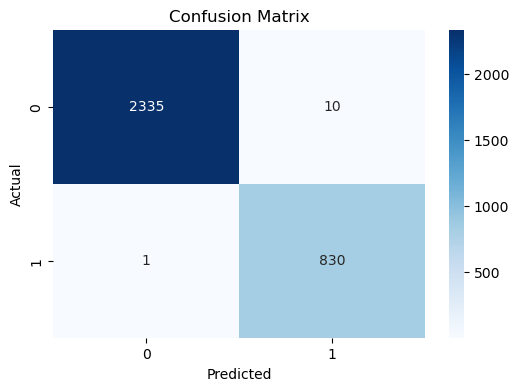

INFO: 
--- Evaluation Results ---
INFO: Exhaustion Prediction - MAE: 0.022792827997819436, R²: 0.9214541410984611
INFO: Injury Risk Prediction - Accuracy: 0.996536523929471, Precision: 0.9880952380952381, Recall: 0.9987966305655837, F1-Score: 0.9934171154997008, ROC-AUC: 0.9999661311800975


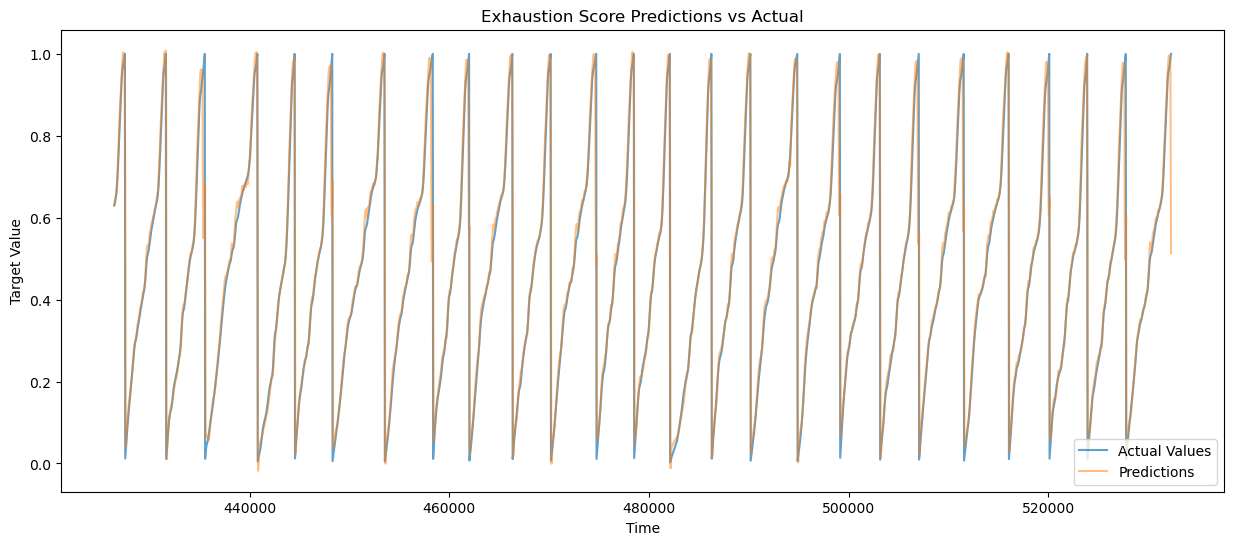

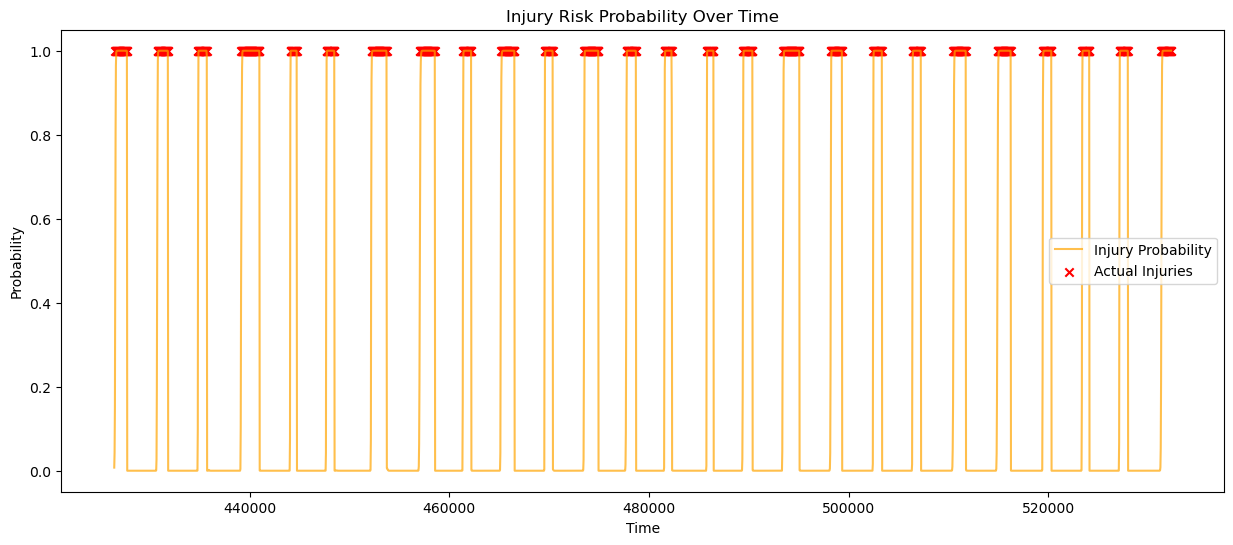

In [4]:


def build_enhanced_lstm(input_shape, target_type='regression'):
    """
    Builds and compiles an enhanced LSTM model with regularization.
    
    Parameters:
    - input_shape (tuple): (timesteps, num_features)
    - target_type (str): 'regression' or 'classification' to set final layer.
    
    Returns:
    - model (Sequential): Compiled LSTM model.
    """
    model = Sequential()
    # First LSTM layer with Dropout
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    # Second LSTM layer with Dropout
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))
    # Dense hidden layer
    model.add(Dense(32, activation='relu'))
    
    if target_type == 'classification':
        # Output layer for binary classification
        model.add(Dense(1, activation='sigmoid'))
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    else:
        # Output layer for regression
        model.add(Dense(1, activation='linear'))
        model.compile(
            optimizer='adam',
            loss='mse',
            metrics=['mae']
        )
    
    logging.info(f"Built {'classification' if target_type == 'classification' else 'regression'} LSTM model with Dropout layers.")
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Trains the LSTM model with Early Stopping.
    
    Parameters:
    - model (Sequential): Compiled LSTM model.
    - X_train (np.array): Training features.
    - y_train (np.array): Training targets.
    - X_val (np.array): Validation features.
    - y_val (np.array): Validation targets.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size.
    
    Returns:
    - history: Training history object.
    """
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    history = model.fit(
        X_train, 
        y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=1
    )
    logging.info(f"Trained model with Early Stopping for up to {epochs} epochs and batch size {batch_size}.")
    return history

def evaluate_model_regression(y_true, y_pred):
    """
    Evaluates regression model performance.

    Parameters:
    - y_true (np.array): True target values.
    - y_pred (np.array): Predicted target values.

    Returns:
    - metrics (dict): Dictionary containing MAE and R².
    """
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    logging.info(f"Regression Model Evaluation - MAE: {mae}, R²: {r2}")
    return {'MAE': mae, 'R2': r2}

def evaluate_model_classification(y_true, y_pred):
    """
    Evaluates classification model performance with comprehensive metrics.
    
    Parameters:
    - y_true (np.array): True target values.
    - y_pred (np.array): Predicted target values (probabilities).
    
    Returns:
    - metrics (dict): Dictionary containing Accuracy, Precision, Recall, F1-Score, ROC-AUC.
    """
    y_pred_binary = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }
    
    logging.info(f"Classification Model Evaluation - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, ROC-AUC: {roc_auc}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return metrics

def plot_predictions(true_values, predictions, model_name, timesteps, time_indices):
    """
    Plots actual vs. predicted values over time.
    
    Parameters:
    - true_values (np.array): Actual target values.
    - predictions (np.array): Predicted target values.
    - model_name (str): Name of the model (for title purposes).
    - timesteps (int): Number of timesteps used in sequences.
    - time_indices (np.array): Array of time indices corresponding to the data.
    """
    plt.figure(figsize=(15, 6))
    adj_time = time_indices[timesteps:]
    plt.plot(adj_time, true_values, label='Actual Values', alpha=0.7)
    plt.plot(adj_time, predictions, label='Predictions', alpha=0.5)
    plt.title(f'{model_name} Predictions vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()

def plot_injury_probabilities(y_true, y_proba, timesteps, time_indices):
    """
    Plots injury risk probabilities over time along with actual injury events.
    
    Parameters:
    - y_true (np.array): Actual injury risk labels.
    - y_proba (np.array): Predicted injury risk probabilities.
    - timesteps (int): Number of timesteps used in sequences.
    - time_indices (np.array): Array of time indices corresponding to the data.
    """
    plt.figure(figsize=(15, 6))
    adj_time = time_indices[timesteps:]
    
    # Plot probability curve
    plt.plot(adj_time, y_proba, label='Injury Probability', color='orange', alpha=0.7)
    
    # Plot actual injury events
    injury_dates = adj_time[y_true == 1]
    plt.scatter(injury_dates, [1]*len(injury_dates), 
                color='red', marker='x', label='Actual Injuries')
    
    plt.title('Injury Risk Probability Over Time')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    # Paths to data files
    csv_path = "../data/processed/final_granular_dataset.csv"
    json_path = "../data/basketball/freethrow/participant_information.json"
    
    # Load and merge data
    data = load_data(csv_path, json_path)
    
    # Prepare joint features and additional engineered features
    data = prepare_joint_features(data)
    data = feature_engineering(data)
    
    # Define features and targets
    features_exhaustion = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_exhaustion = 'by_trial_exhaustion_score'
    
    features_injury = [
        'joint_power', 
        'joint_energy', 
        'elbow_asymmetry',  # Updated from 'elbow_angle' to 'elbow_asymmetry'
        'knee_asymmetry', 
        'wrist_angle', 
        'exhaustion_lag1', 
        'power_avg_5',
        'simulated_HR',
        'player_height_in_meters',
        'player_weight__in_kg'
    ]
    target_injury = 'injury_risk'
    
    # Verify all features exist in the DataFrame
    missing_features = [
        feature for feature in features_exhaustion + features_injury 
        if feature not in data.columns
    ]
    if missing_features:
        logging.error(f"Missing features detected: {missing_features}")
        logging.error("Please ensure all required features are present in the dataset.")
        sys.exit(1)
    else:
        logging.info("All required features are present.")
    
    # Split data into training and testing sets based on time
    # Unified temporal split
    train_data, test_data = temporal_train_test_split(data)
    train_exhaustion = train_data.copy()
    test_exhaustion = test_data.copy()
    train_injury = train_data.copy()
    test_injury = test_data.copy()
    
    # Extract features and targets for exhaustion prediction
    X_train_exhaustion = train_exhaustion[features_exhaustion].values
    y_train_exhaustion = train_exhaustion[target_exhaustion].values
    X_test_exhaustion = test_exhaustion[features_exhaustion].values
    y_test_exhaustion = test_exhaustion[target_exhaustion].values
    
    # Extract features and targets for injury risk prediction
    X_train_injury = train_injury[features_injury].values
    y_train_injury = train_injury[target_injury].values
    X_test_injury = test_injury[features_injury].values
    y_test_injury = test_injury[target_injury].values
    
    # Scale features
    X_train_exhaustion_scaled, X_test_exhaustion_scaled, scaler_exhaustion = scale_features(X_train_exhaustion, X_test_exhaustion)
    X_train_injury_scaled, X_test_injury_scaled, scaler_injury = scale_features(X_train_injury, X_test_injury)
    
    # Define number of timesteps for LSTM
    timesteps = 5
    
    # Create sequences for LSTM
    X_lstm_exhaustion, y_lstm_exhaustion = create_sequences(X_train_exhaustion_scaled, y_train_exhaustion, timesteps)
    X_lstm_exhaustion_val, y_lstm_exhaustion_val = create_sequences(X_test_exhaustion_scaled, y_test_exhaustion, timesteps)
    
    X_lstm_injury, y_lstm_injury = create_sequences(X_train_injury_scaled, y_train_injury, timesteps)
    X_lstm_injury_val, y_lstm_injury_val = create_sequences(X_test_injury_scaled, y_test_injury, timesteps)
    
    # Build and train LSTM model for exhaustion (regression)
    model_exhaustion = build_enhanced_lstm(
        input_shape=(timesteps, len(features_exhaustion)),
        target_type='regression'
    )
    history_exhaustion = train_model(
        model_exhaustion,
        X_lstm_exhaustion,
        y_lstm_exhaustion,
        X_lstm_exhaustion_val,
        y_lstm_exhaustion_val,
        epochs=100,  # Increased epochs for enhanced training
        batch_size=32
    )
    
    # Build and train LSTM model for injury risk (classification)
    model_injury = build_enhanced_lstm(
        input_shape=(timesteps, len(features_injury)),
        target_type='classification'
    )
    history_injury = train_model(
        model_injury,
        X_lstm_injury,
        y_lstm_injury,
        X_lstm_injury_val,
        y_lstm_injury_val,
        epochs=100,  # Increased epochs for enhanced training
        batch_size=32
    )
    
    # Make predictions
    y_pred_exhaustion = model_exhaustion.predict(X_lstm_exhaustion_val)
    y_pred_injury = model_injury.predict(X_lstm_injury_val)
    
    # Evaluate models
    eval_exhaustion = evaluate_model_regression(y_lstm_exhaustion_val, y_pred_exhaustion)
    eval_injury = evaluate_model_classification(y_lstm_injury_val, y_pred_injury)
    
    # Display Evaluation Results
    logging.info("\n--- Evaluation Results ---")
    logging.info(f"Exhaustion Prediction - MAE: {eval_exhaustion['MAE']}, R²: {eval_exhaustion['R2']}")
    logging.info(f"Injury Risk Prediction - Accuracy: {eval_injury['Accuracy']}, "
                 f"Precision: {eval_injury['Precision']}, Recall: {eval_injury['Recall']}, "
                 f"F1-Score: {eval_injury['F1-Score']}, ROC-AUC: {eval_injury['ROC-AUC']}")
    
    # Advanced Visualization
    plot_predictions(
        y_lstm_exhaustion_val,
        y_pred_exhaustion.flatten(),
        'Exhaustion Score',
        timesteps,
        test_exhaustion['continuous_frame_time'].values
    )
    
    plot_injury_probabilities(
        y_lstm_injury_val,
        y_pred_injury.flatten(),
        timesteps,
        test_injury['continuous_frame_time'].values
    )